# Preparation

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
from pathlib import Path
import os
import re

In [68]:
tests = [1, 2, 3]

Some one-liners that help us sort naturally...

In [46]:
convert = lambda text: int(text) if text.isdigit() else text
alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]

In [70]:
def get_files(test):

    latency_files = glob.glob(f"in/test-{test}/latency_*-*.csv")
    svr_files = glob.glob(f"in/test-{test}/sent-vs-received_*-*.csv")

    return sorted(latency_files, key=alphanum_key), sorted(svr_files, key=alphanum_key)

# Working with converted CSVs

In [71]:
def parse_filename(filename: str):
    m = re.match(".+/(latency|sent-vs-received)_([0-9]+)-([0-9]+)\.csv", filename)
    return m.group(2), m.group(3)

In [76]:
Path(f"out").mkdir(parents=True, exist_ok=True)

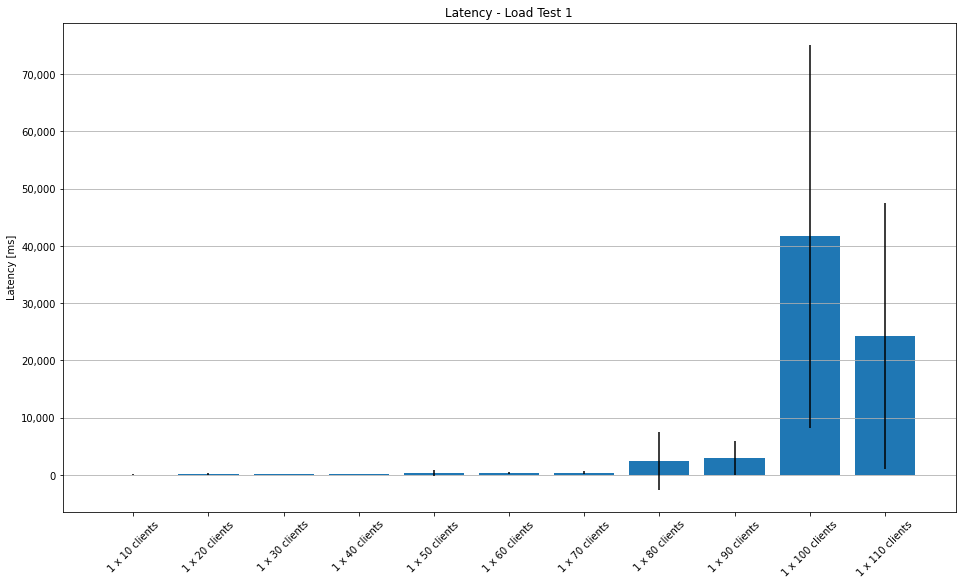

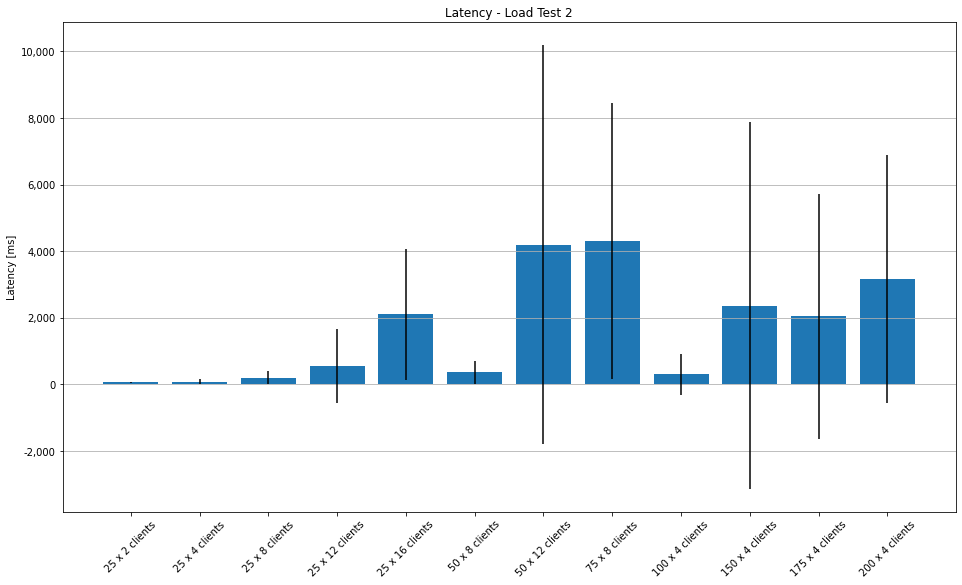

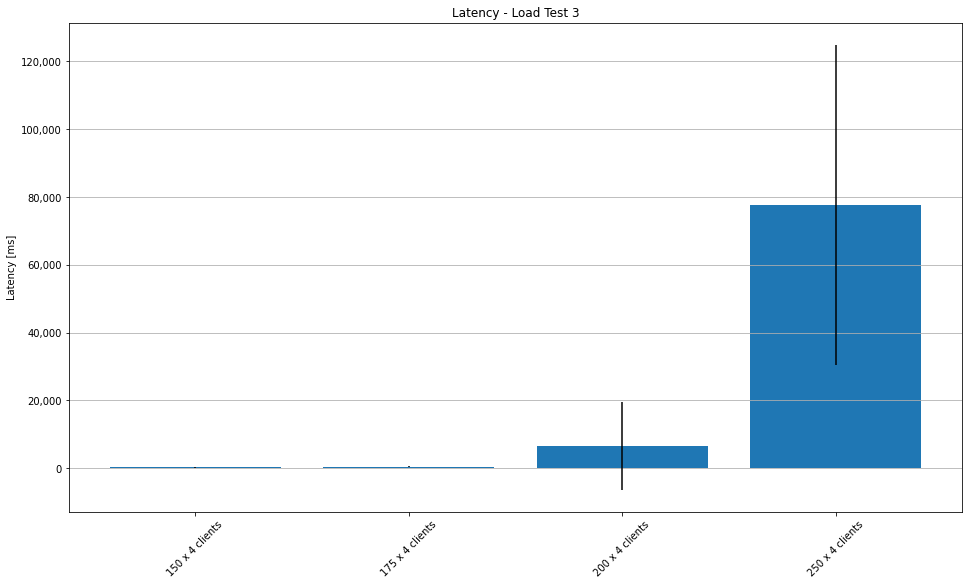

In [77]:
def render_plot(
    label: str,
    title: str,
    files,
    column: str = "latency",
    filename: str | None = None,
):
    fig, ax = plt.subplots(figsize=(16, 9))

    labels = [parse_filename(name) for name in files]
    labels = [f"{t[0]} x {t[1]} clients" for t in labels]
    x_pos = np.arange(len(labels))
    y_pos = []
    y_err = []

    for file in files:
        df = pd.read_csv(file)
        y_pos.append(np.mean(df[column]) / 1000)
        y_err.append(np.std(df[column]) / 1000)

    ax.bar(
        x_pos,
        y_pos,
        yerr=y_err,
        align="center",
        ecolor="black",
    )
    ax.set_ylabel(f"{label} [ms]")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_title(title)
    ax.yaxis.grid(True)

    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
    )

    if filename:
        plt.savefig(filename)
    plt.show()

for test in tests:
    latency_files, svr_files = get_files(test)
    render_plot("Latency", f"Latency - Load Test {test}", latency_files, "latency", f"out/latency_test-{test}.png")

# Percentiles

In [82]:
def calc_percentiles(test, files):
    for file in files:
        room_count, room_size = parse_filename(file)
        df = pd.read_csv(file)
        for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
            p = int(np.round(np.percentile(df["latency"], i) / 1000))
            print(f"Load test {test} | {room_count} x {room_size} Clients – Percentile {i}: {p} ms")
        print("-" * 80)


for test in tests:
    latency_files, svr_files = get_files(test)
    calc_percentiles(test, latency_files)

Load test 1 | 1 x 10 Clients – Percentile 10: 40 ms
Load test 1 | 1 x 10 Clients – Percentile 20: 55 ms
Load test 1 | 1 x 10 Clients – Percentile 30: 68 ms
Load test 1 | 1 x 10 Clients – Percentile 40: 76 ms
Load test 1 | 1 x 10 Clients – Percentile 50: 82 ms
Load test 1 | 1 x 10 Clients – Percentile 60: 86 ms
Load test 1 | 1 x 10 Clients – Percentile 70: 91 ms
Load test 1 | 1 x 10 Clients – Percentile 80: 98 ms
Load test 1 | 1 x 10 Clients – Percentile 90: 122 ms
Load test 1 | 1 x 10 Clients – Percentile 95: 133 ms
Load test 1 | 1 x 10 Clients – Percentile 99: 183 ms
--------------------------------------------------------------------------------
Load test 1 | 1 x 20 Clients – Percentile 10: 65 ms
Load test 1 | 1 x 20 Clients – Percentile 20: 82 ms
Load test 1 | 1 x 20 Clients – Percentile 30: 93 ms
Load test 1 | 1 x 20 Clients – Percentile 40: 102 ms
Load test 1 | 1 x 20 Clients – Percentile 50: 114 ms
Load test 1 | 1 x 20 Clients – Percentile 60: 129 ms
Load test 1 | 1 x 20 Clients 

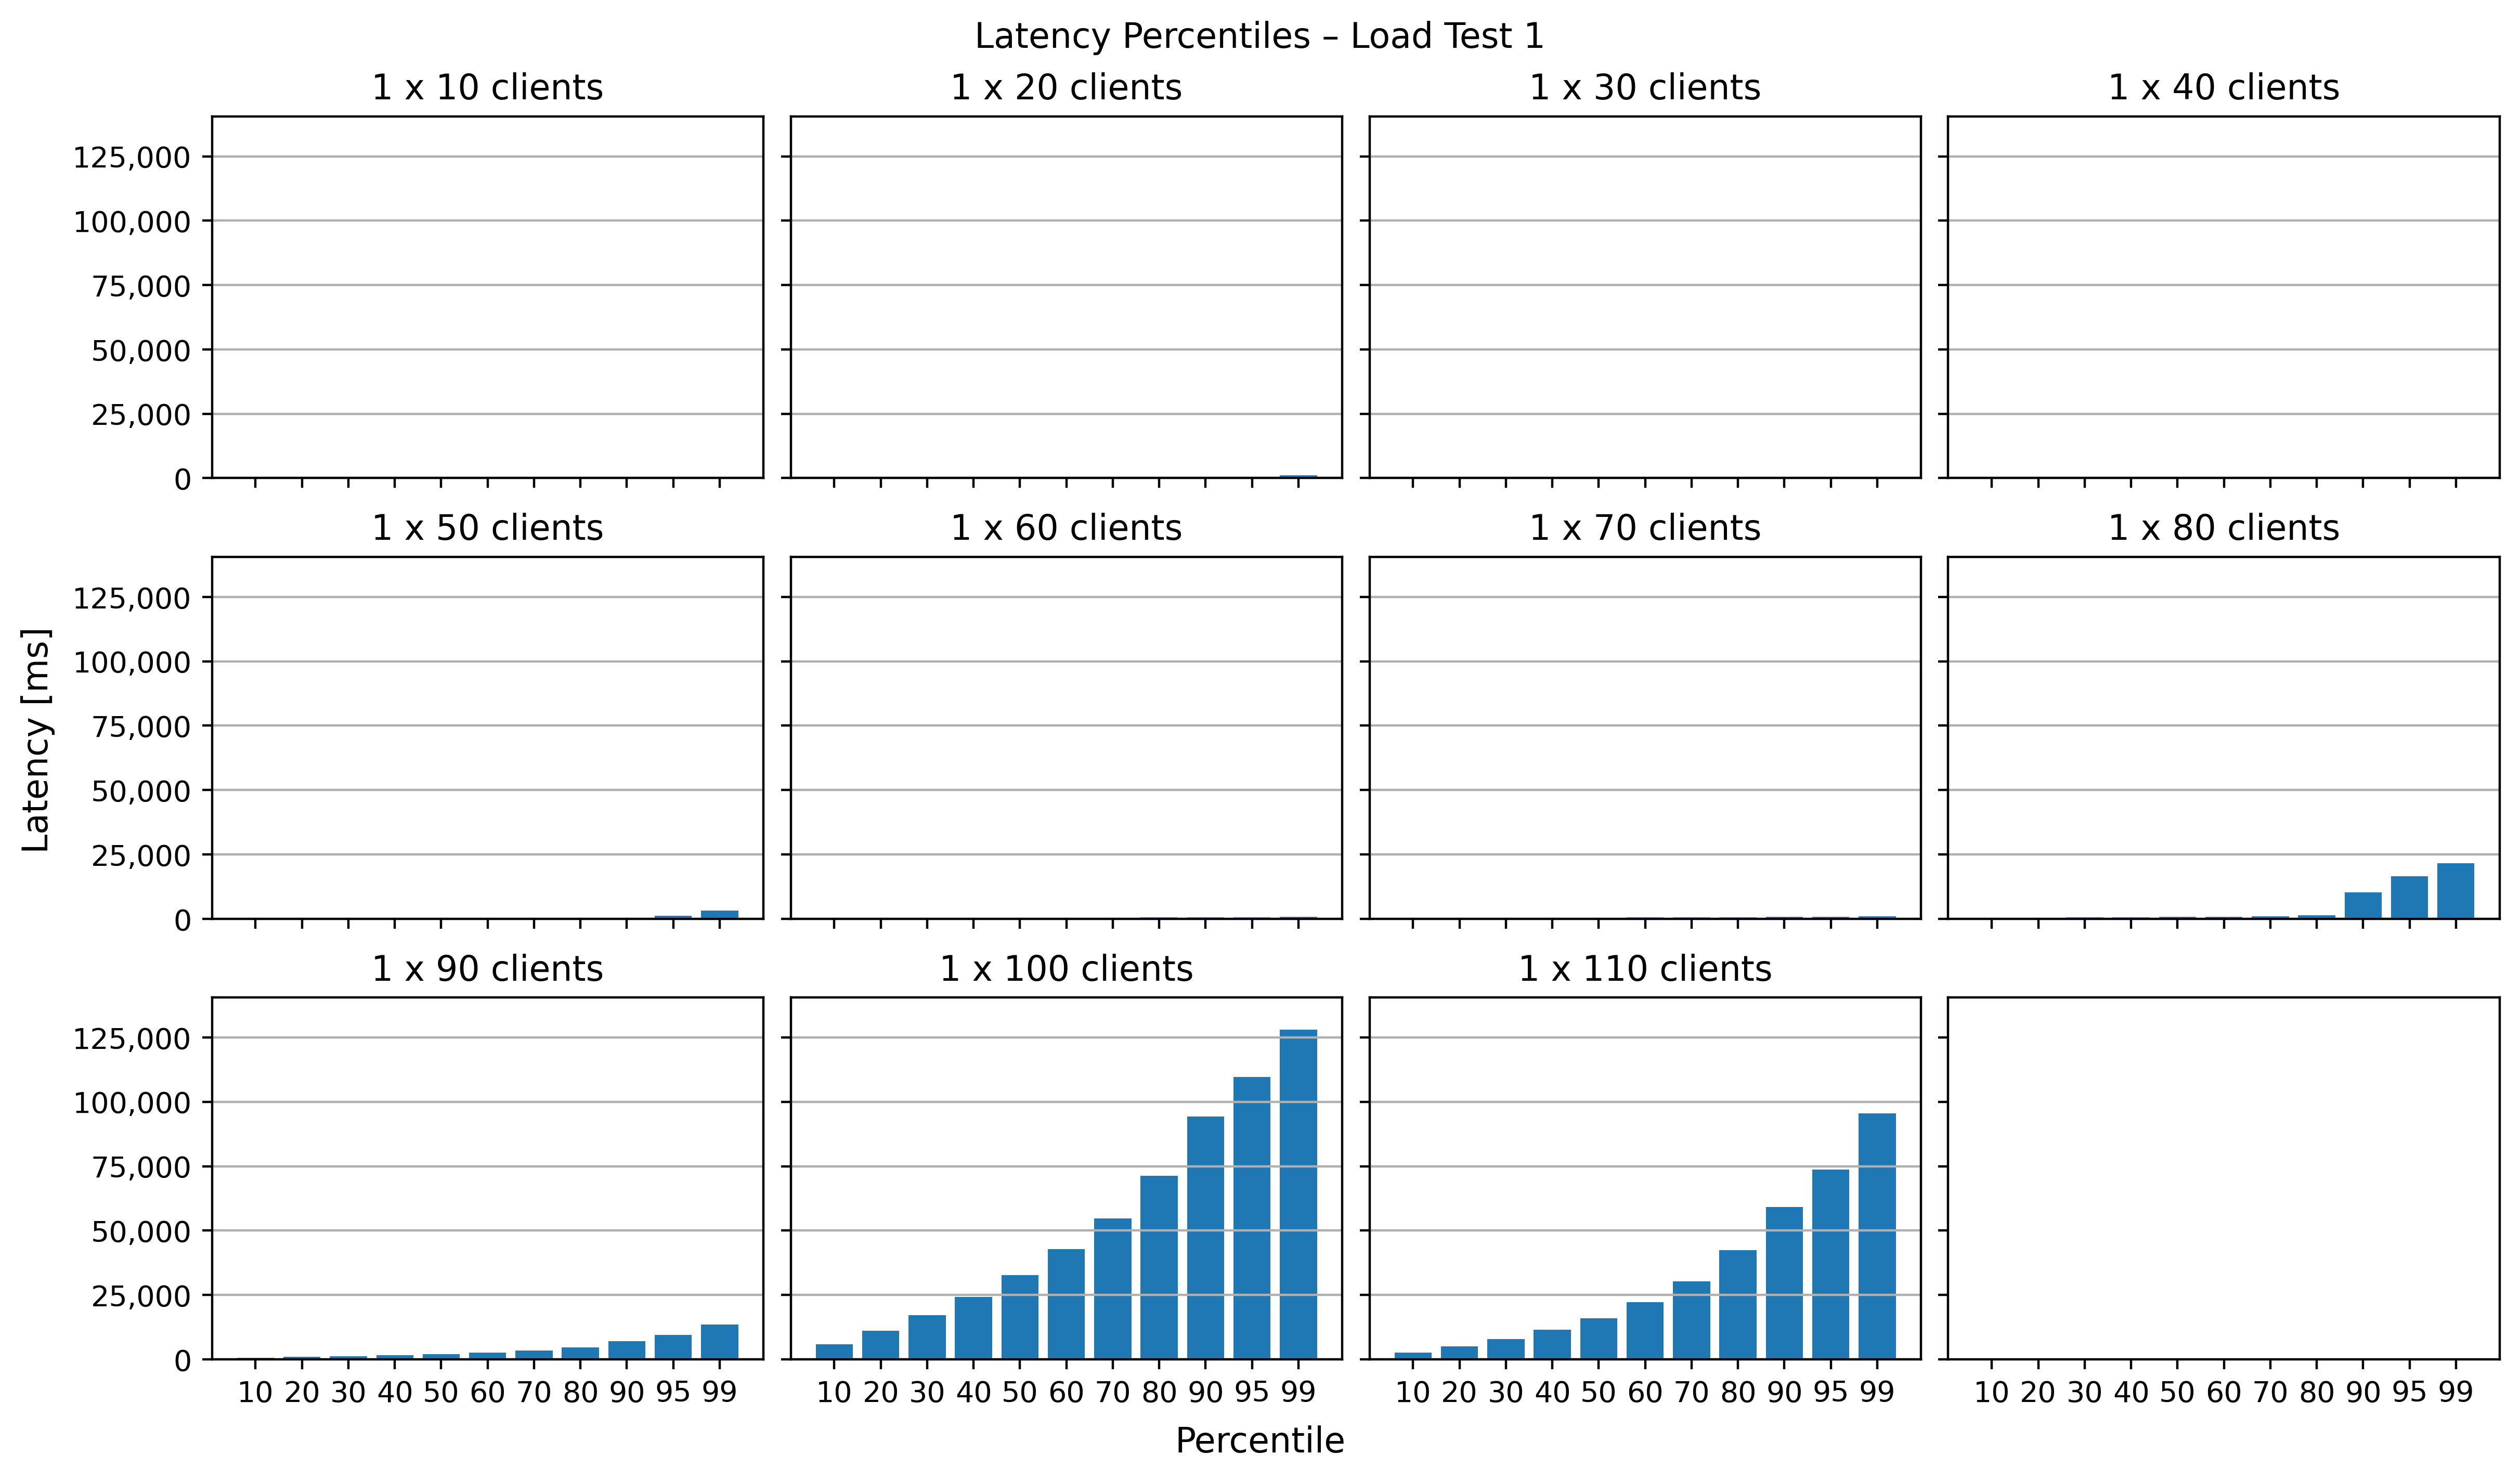

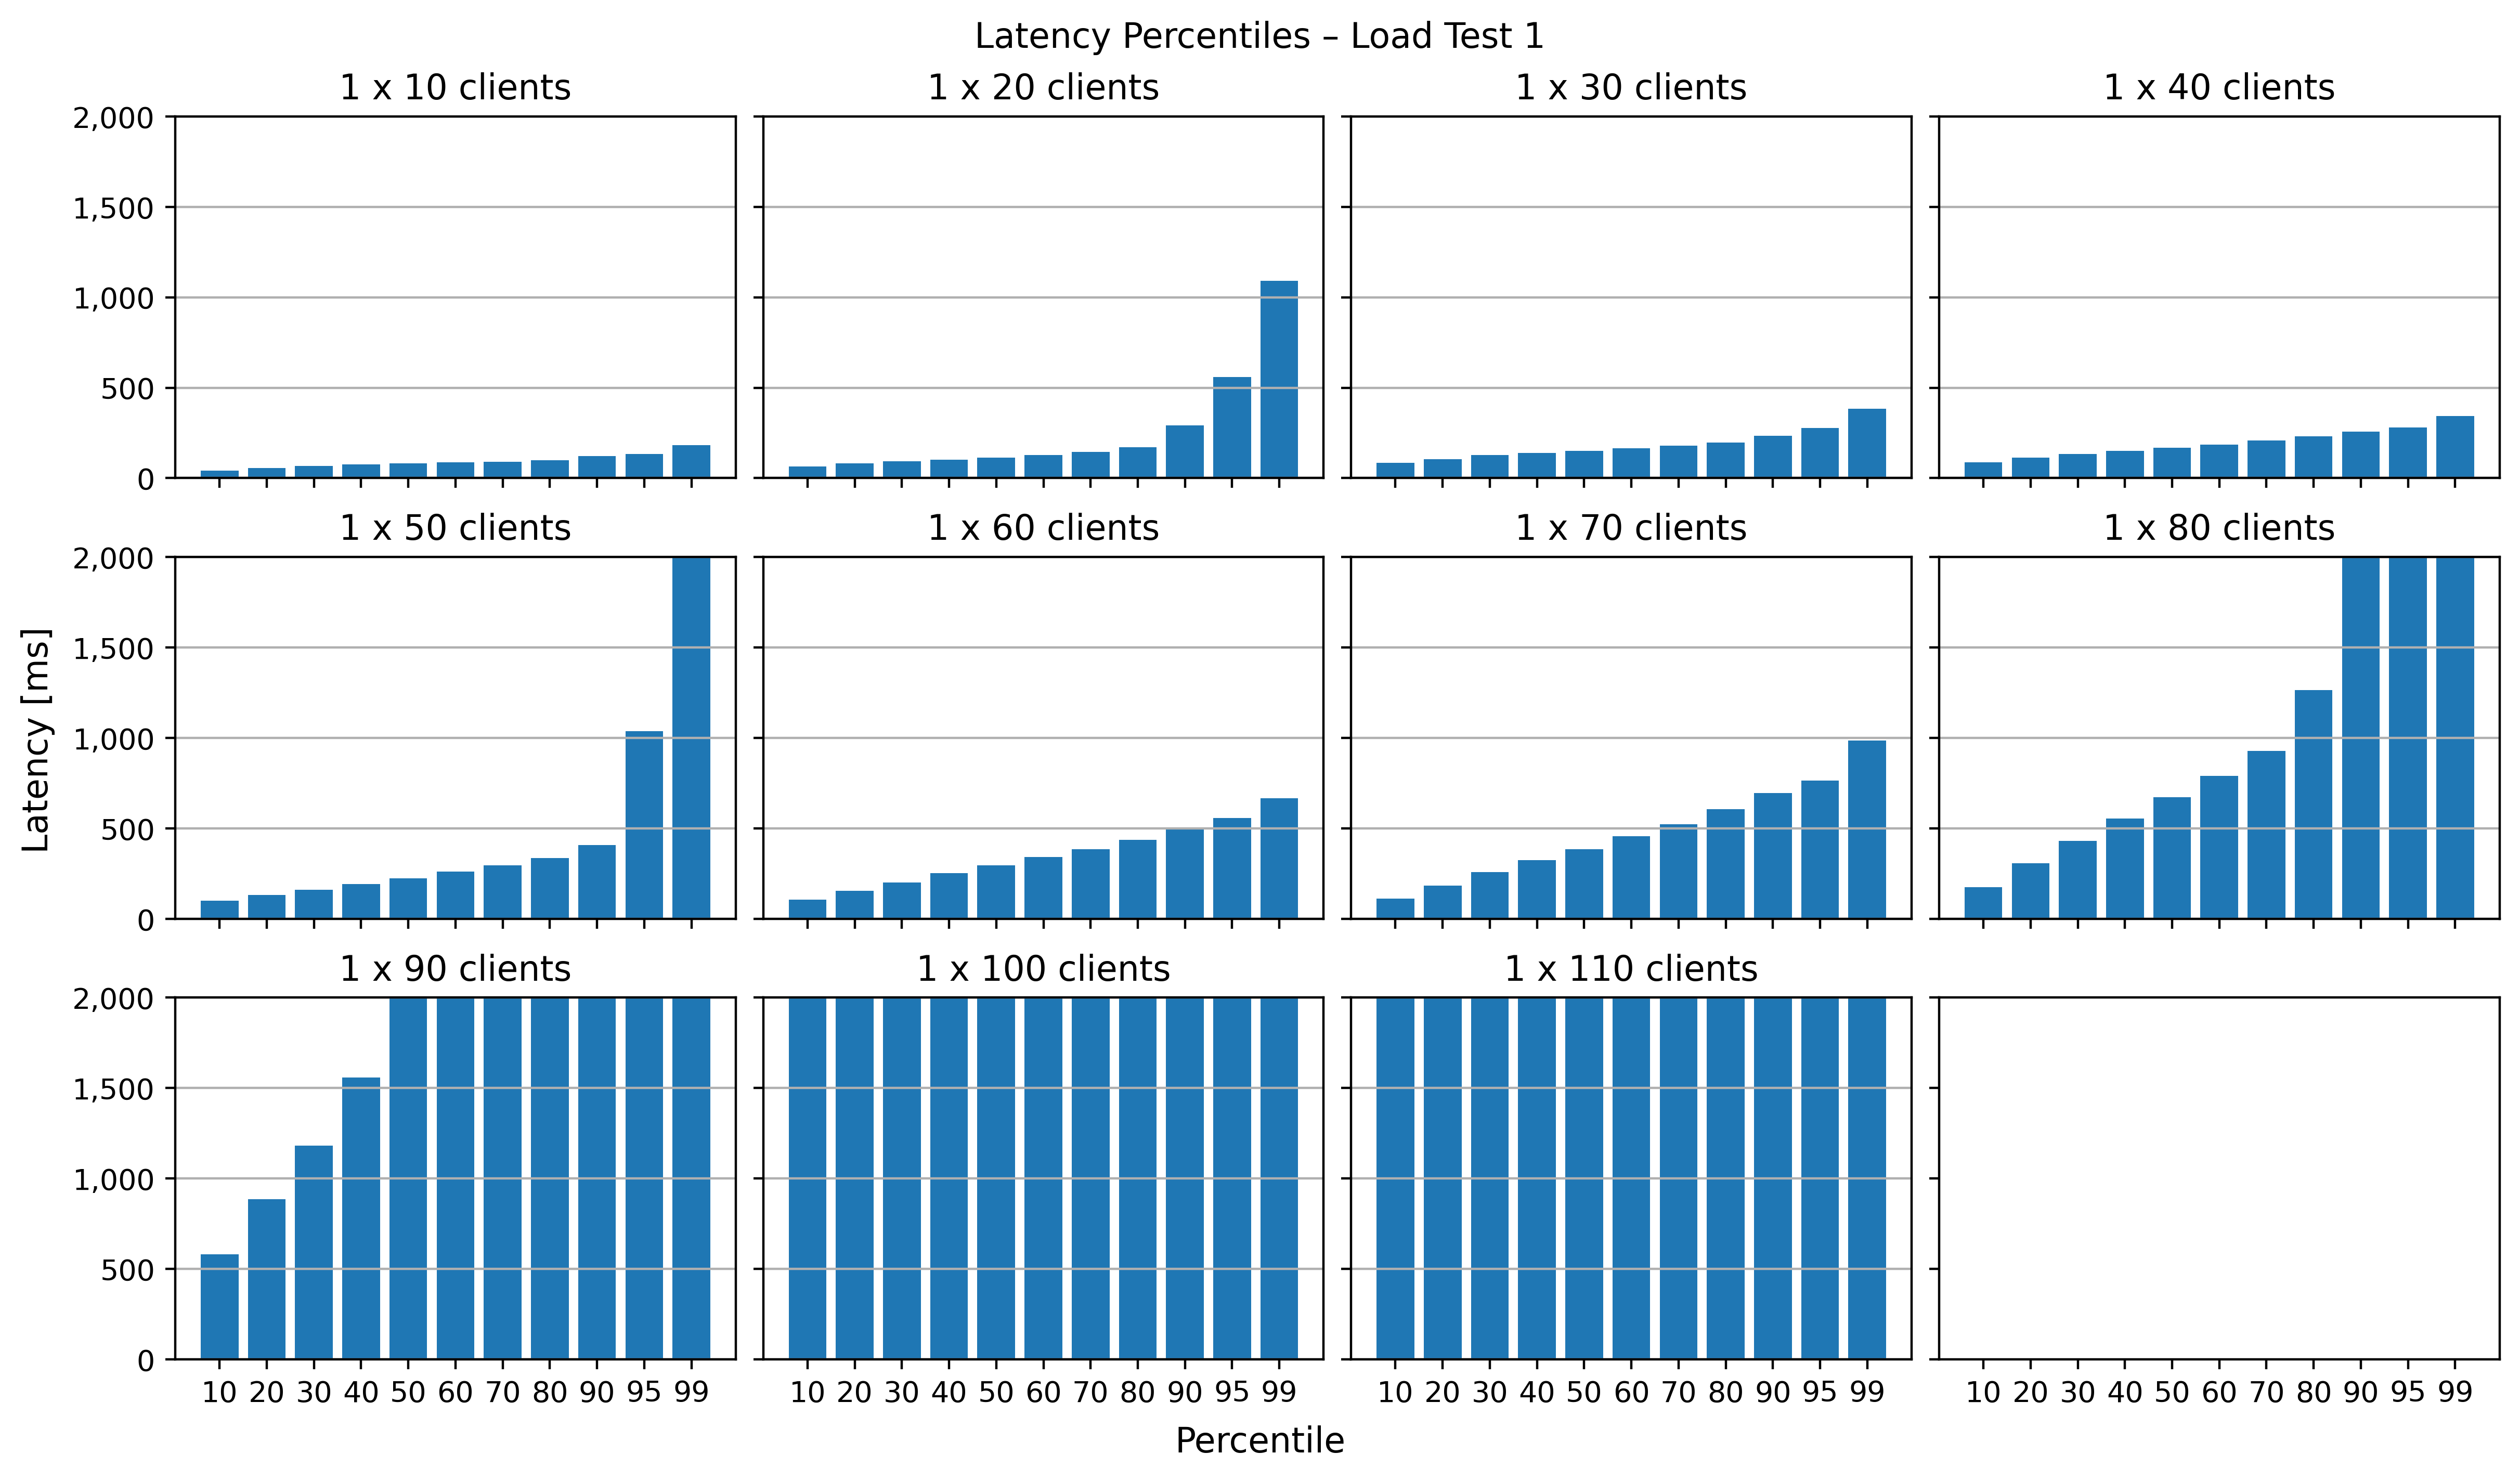

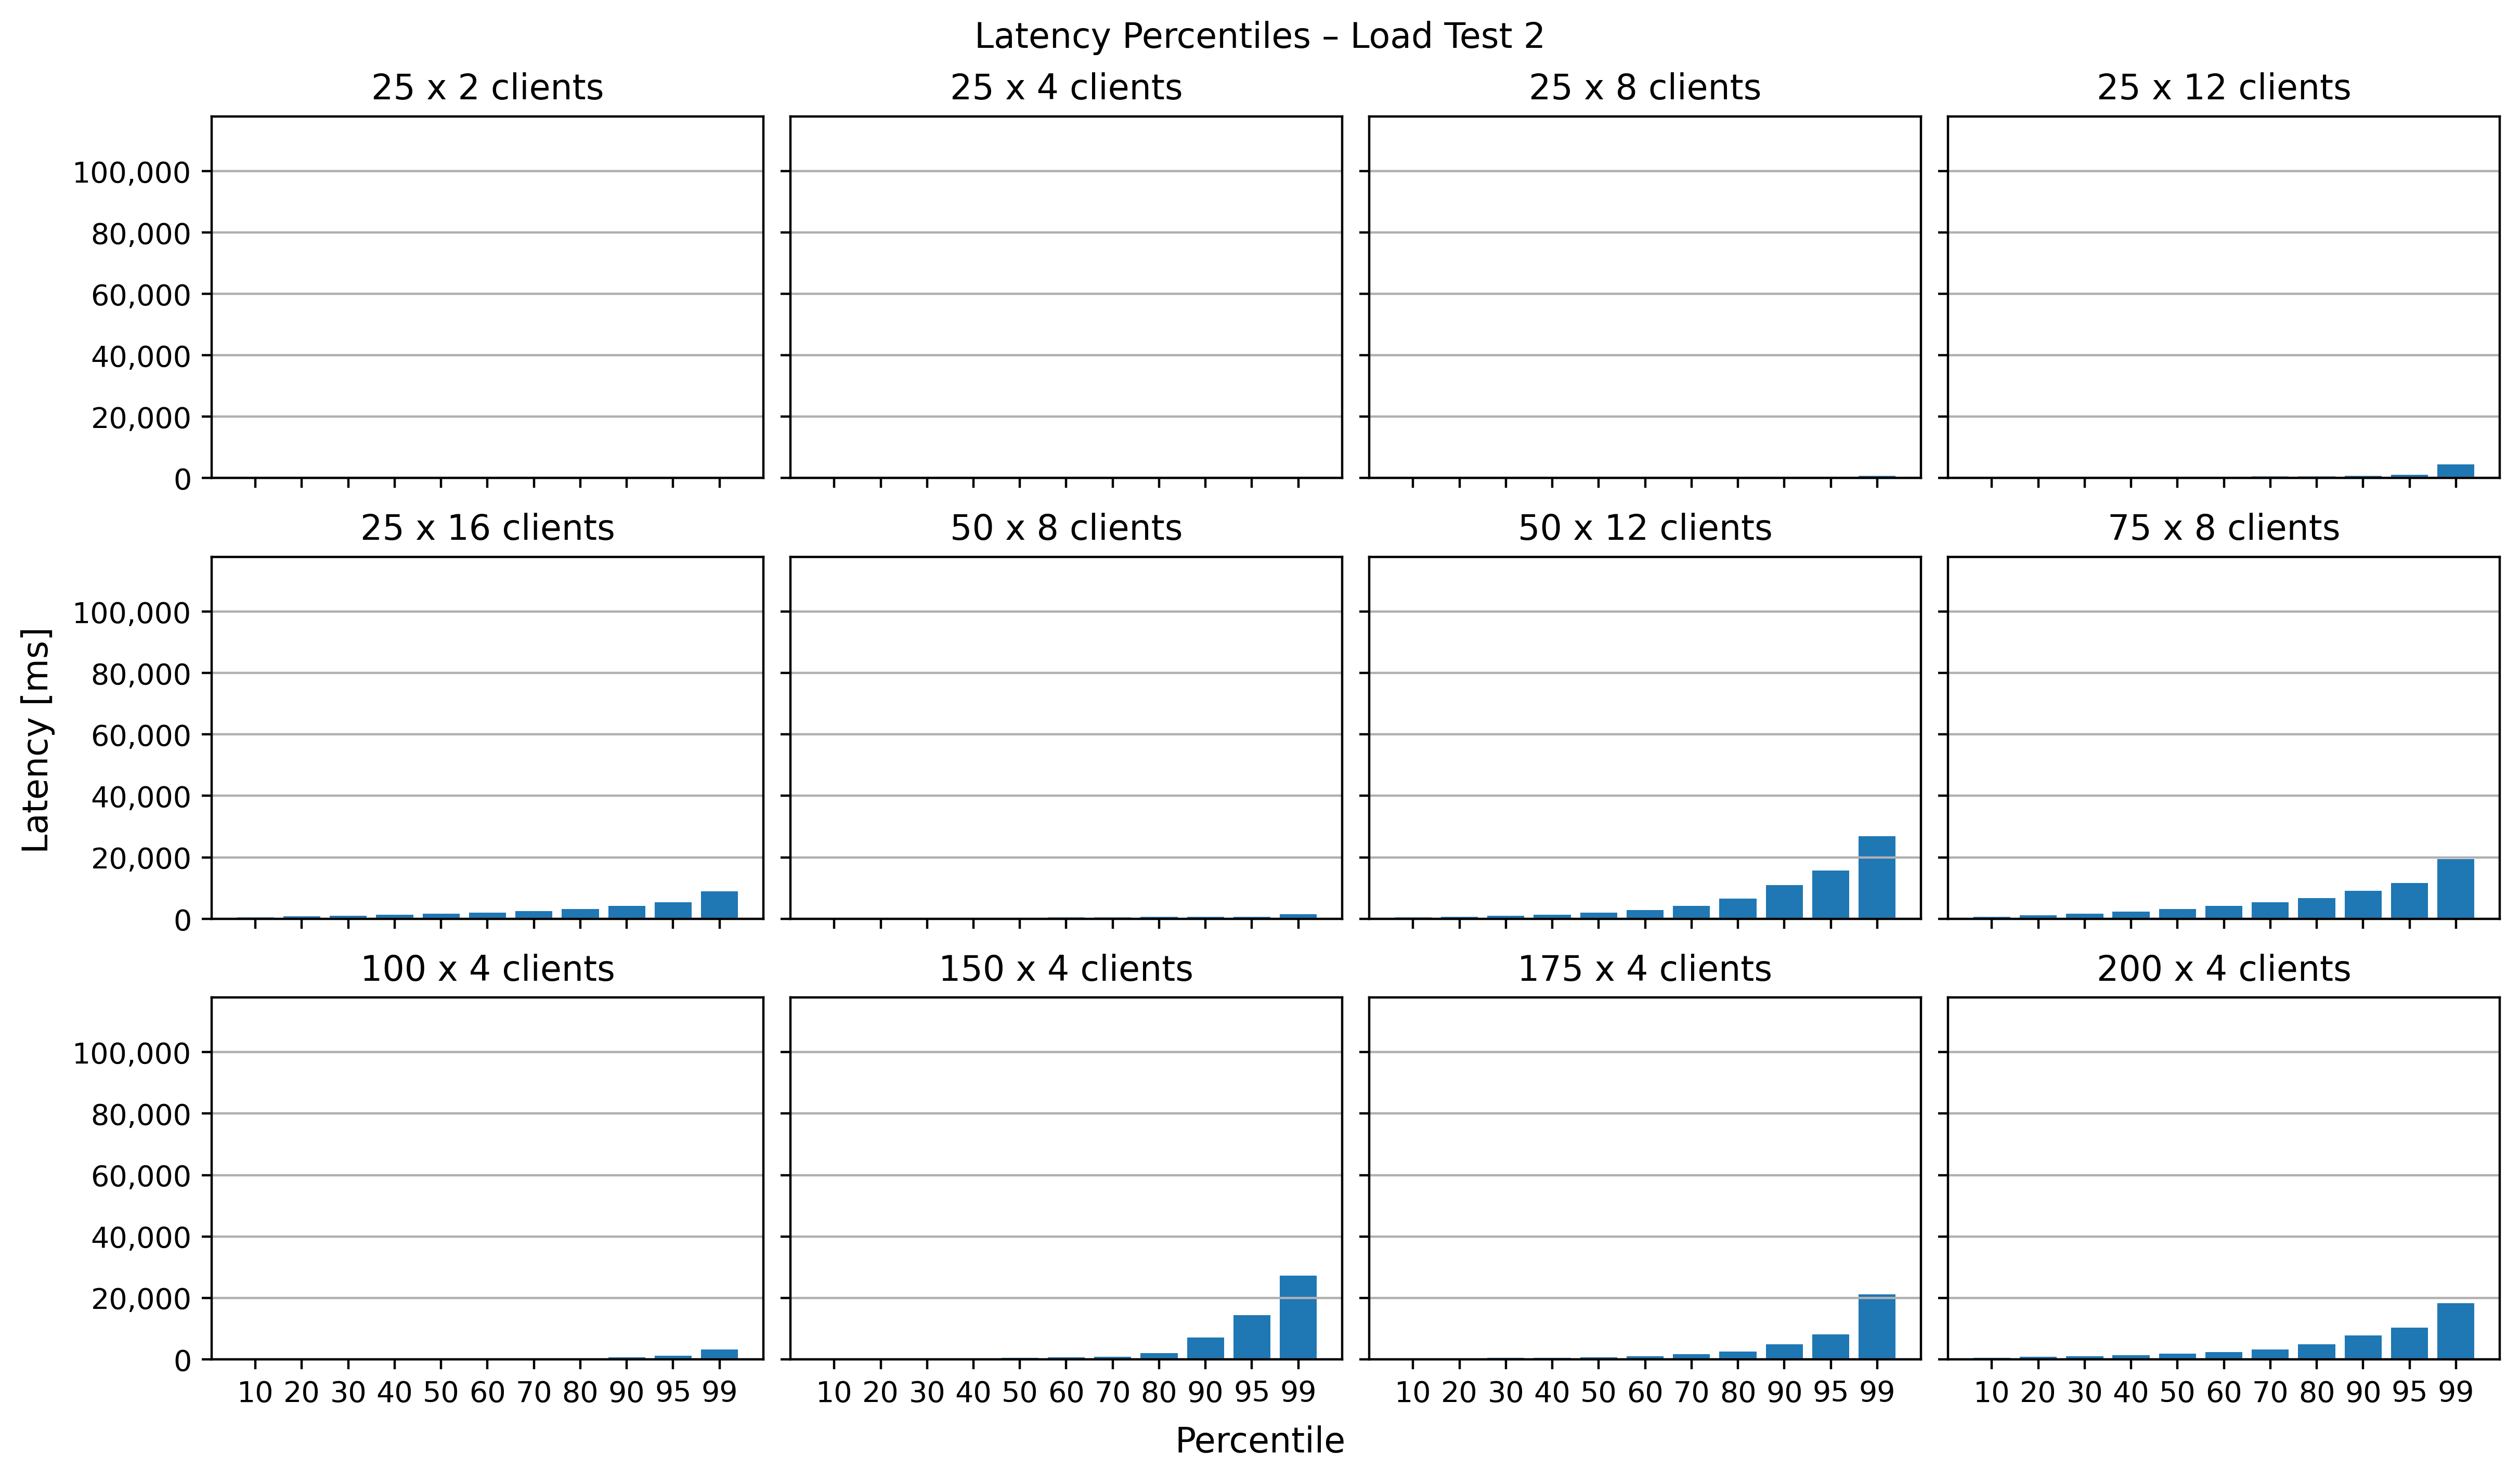

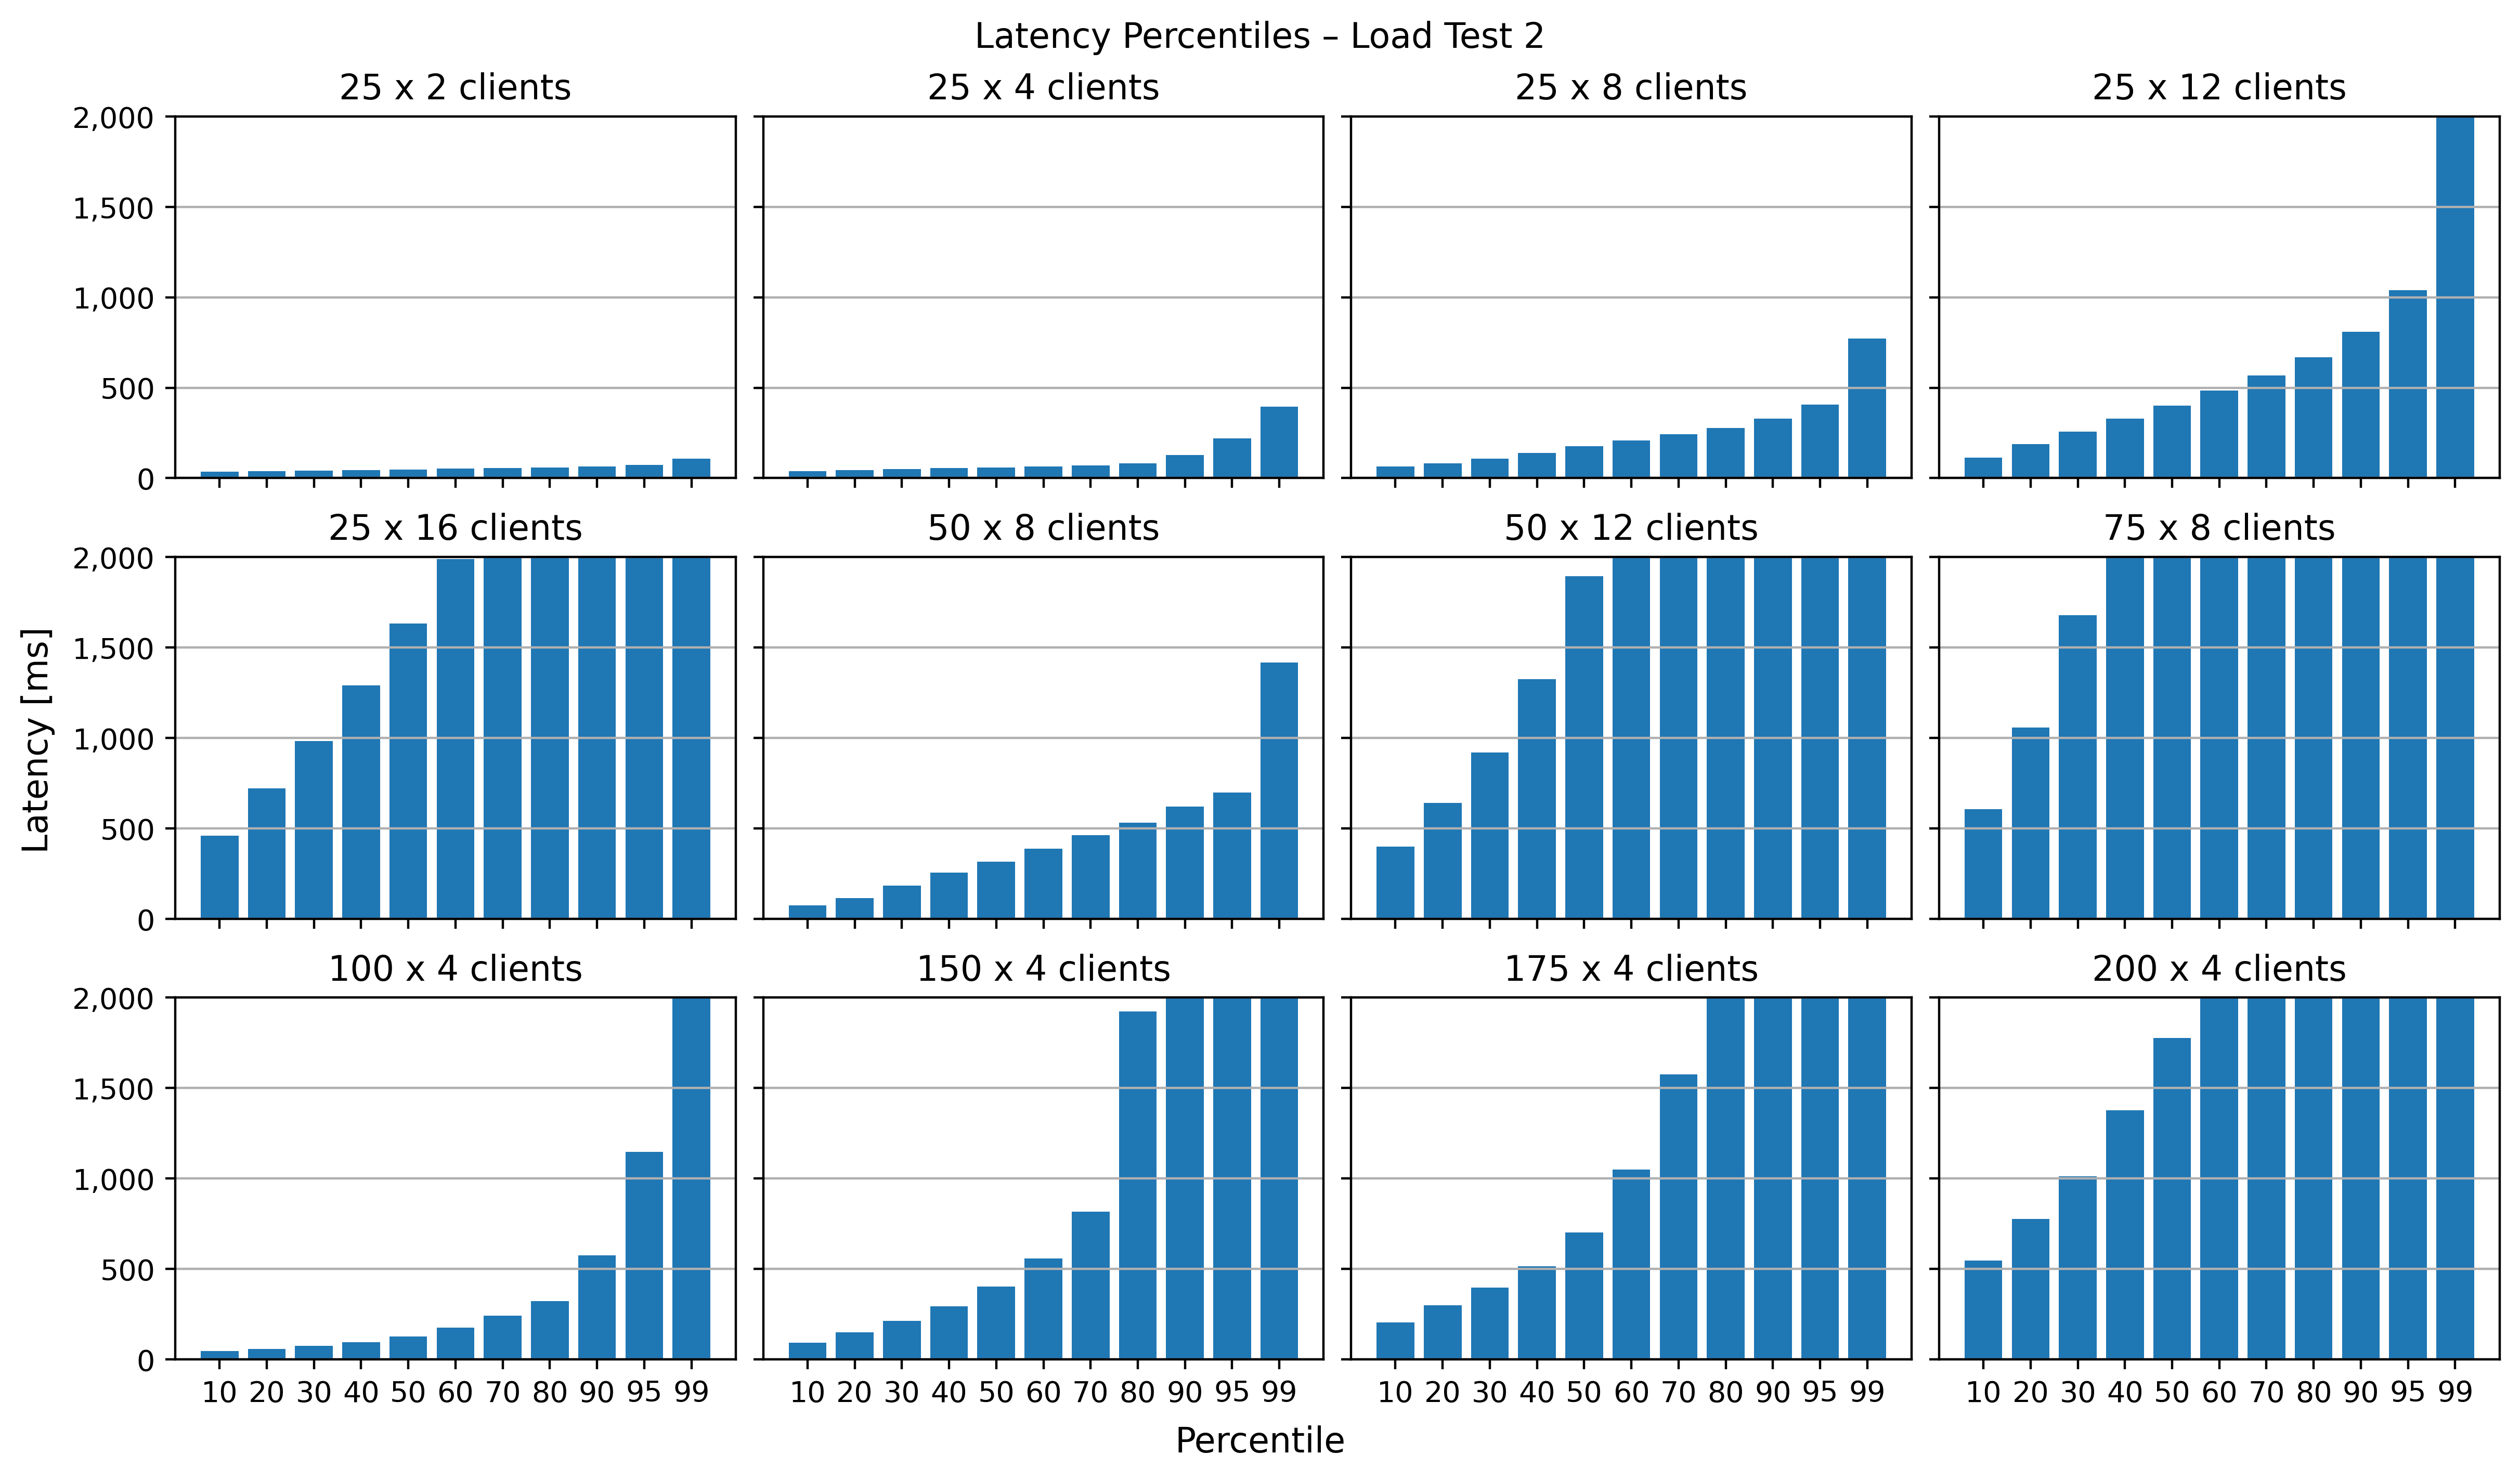

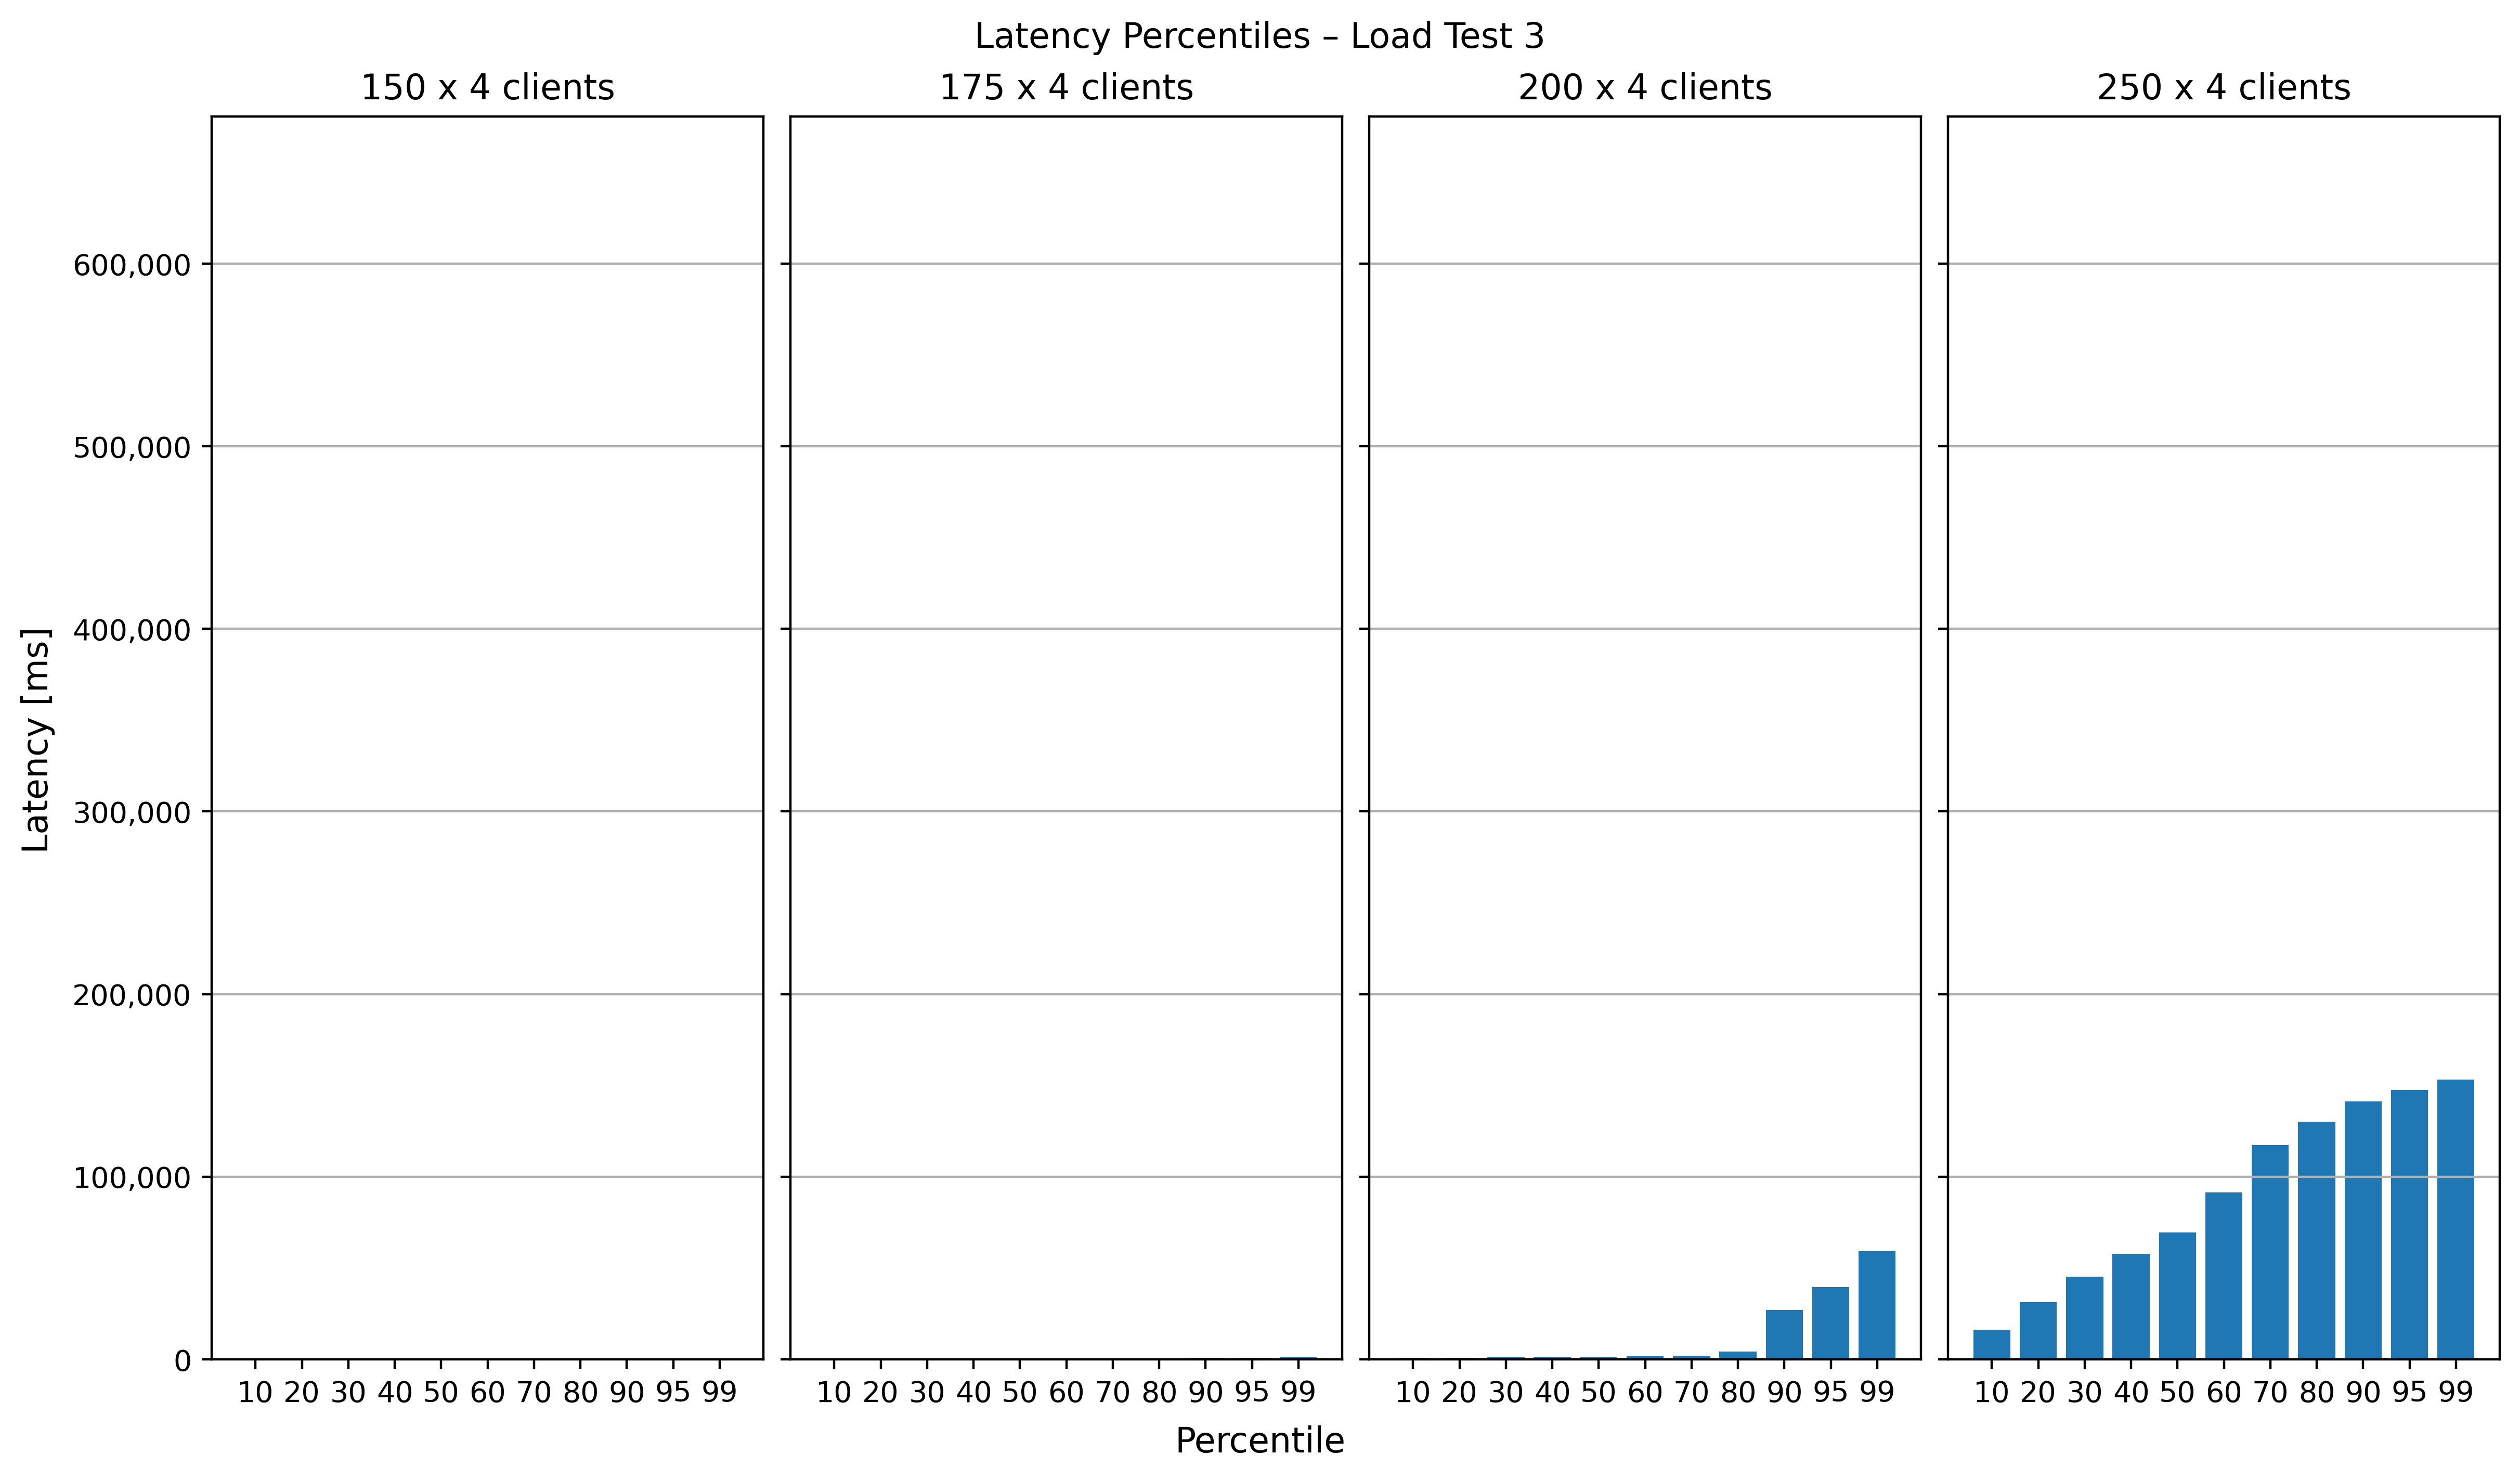

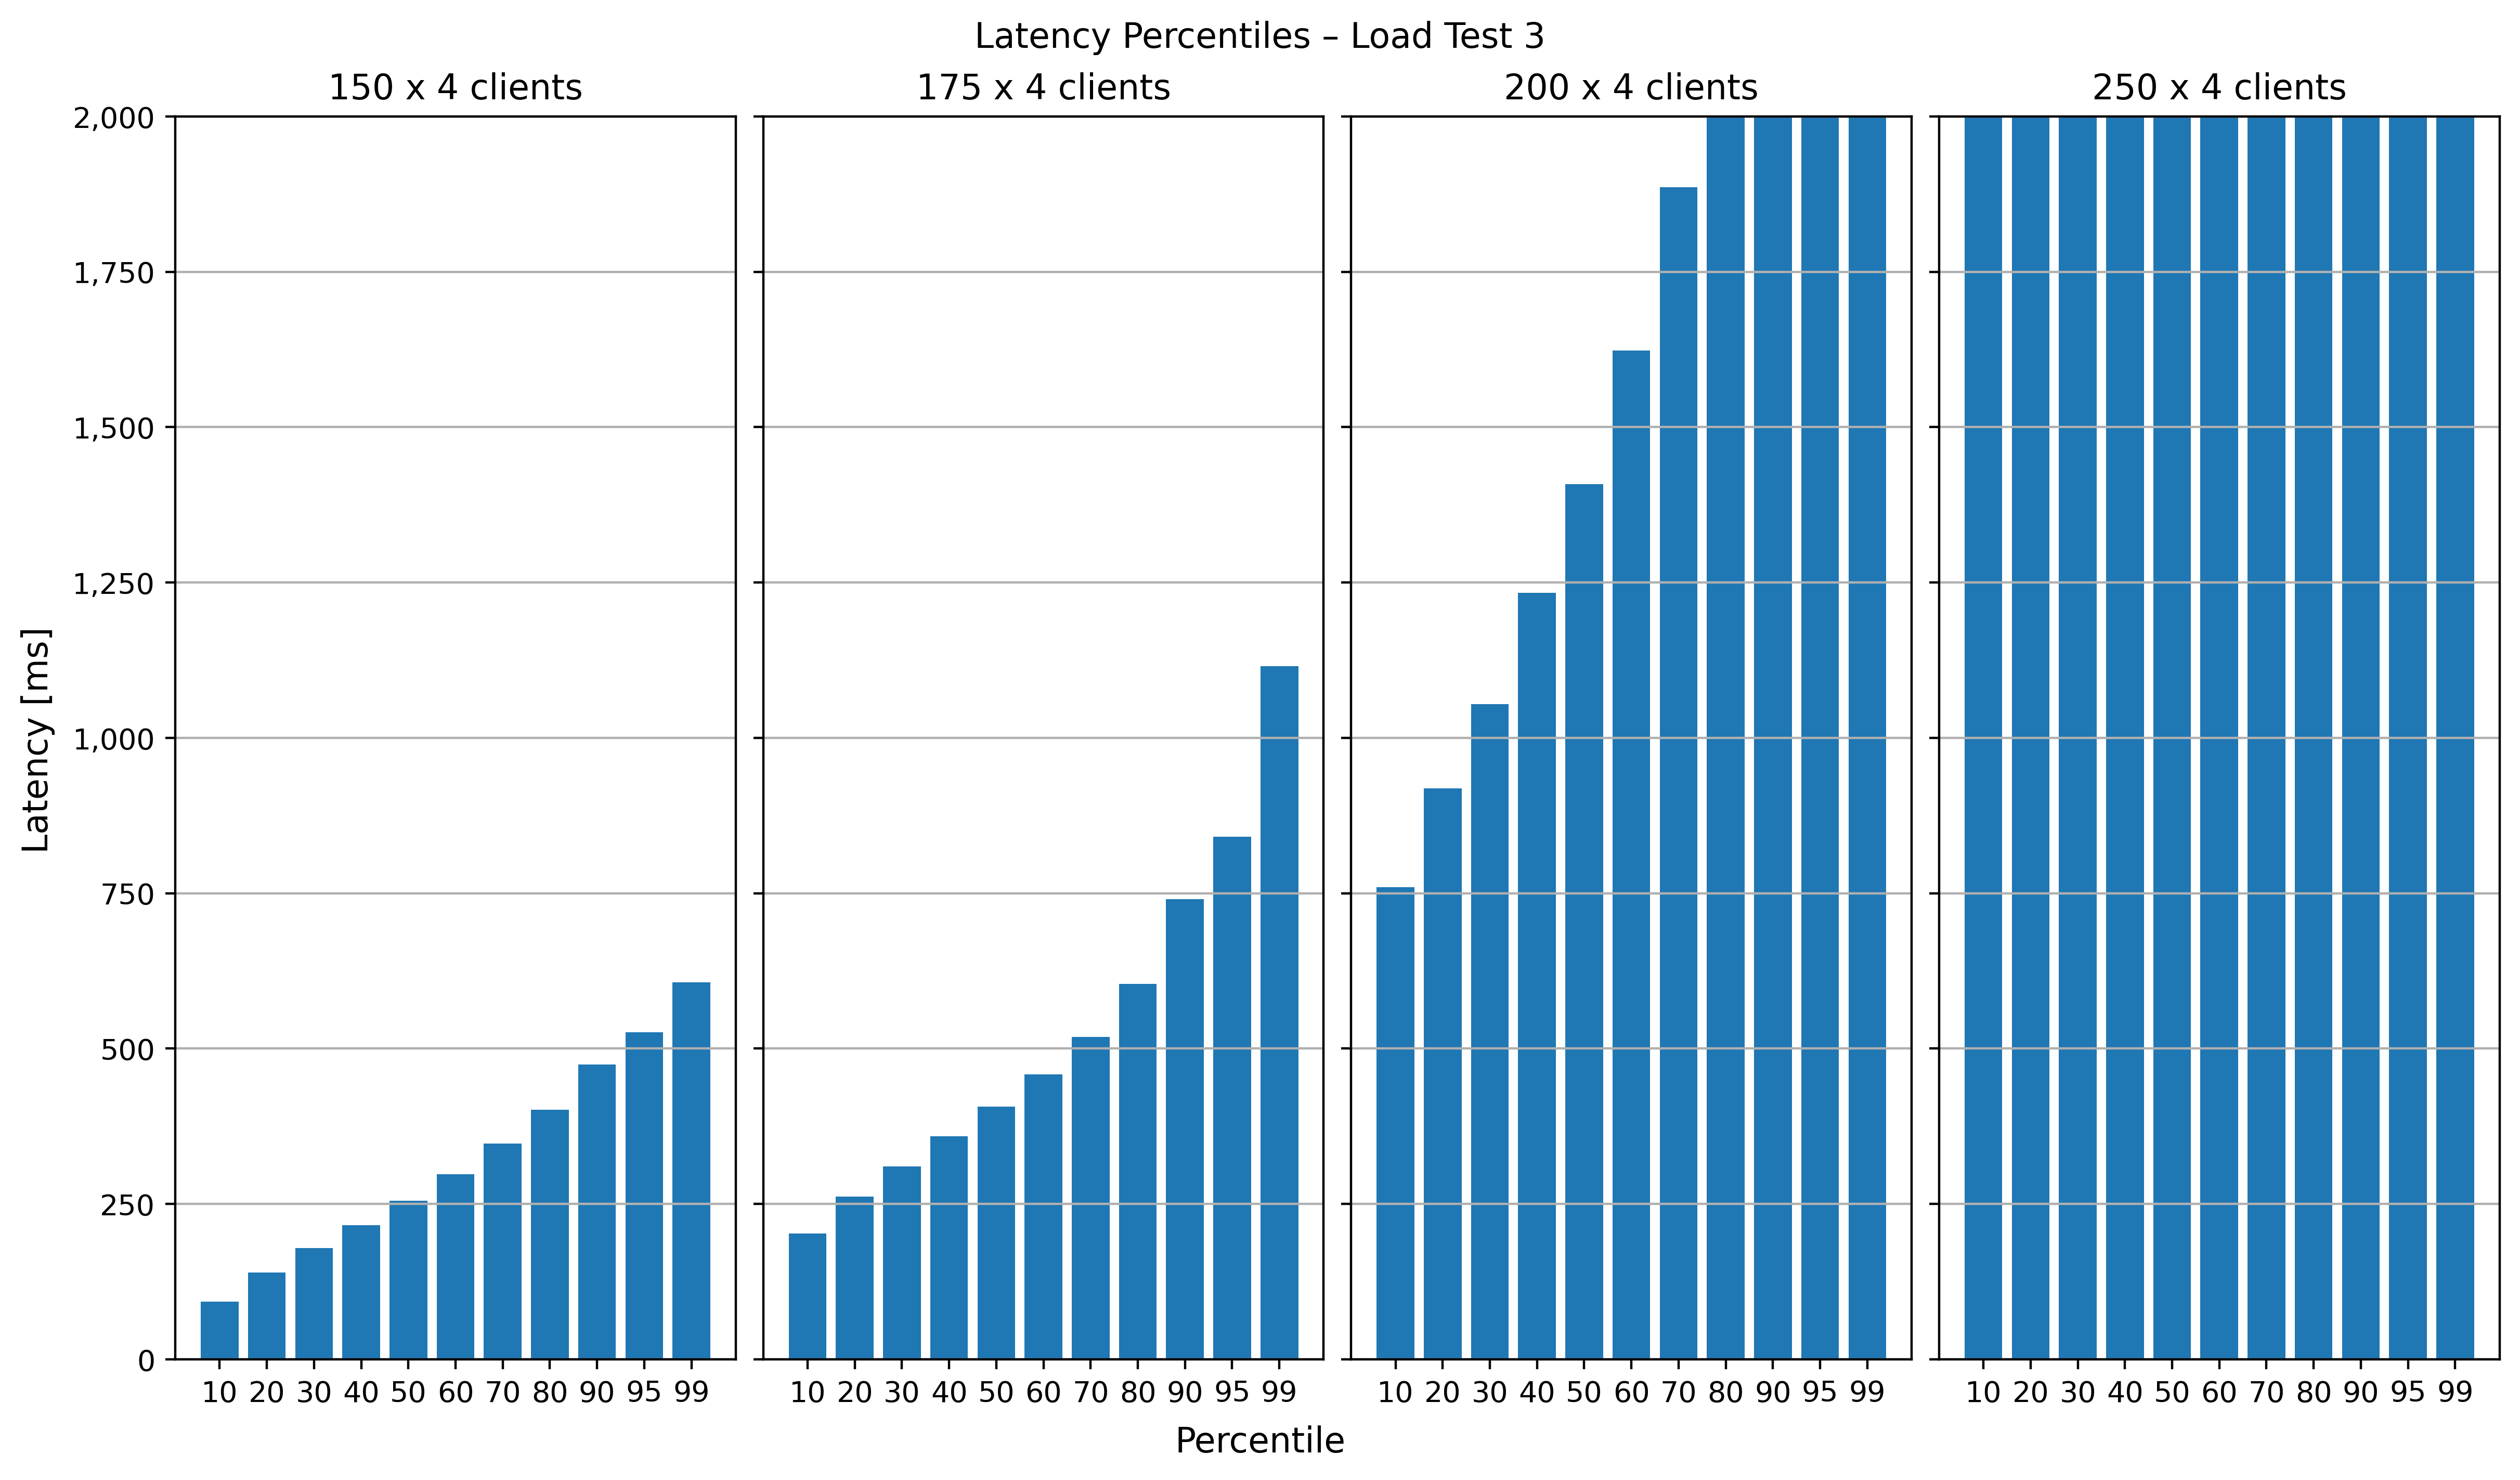

In [86]:
def render_percentiles(test, files: list[str], filename: str|None = None, y_lim = None):
    percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
    dfs = dict()

    for file in files:
        dfs[file] = pd.read_csv(file)

    total_max = 0
    for name, df in dfs.items():
        max = df["latency"].max()
        if max > total_max:
            total_max = max
    total_max = total_max / 1000

    fig, axs = plt.subplots(
        int(np.ceil(len(files) / 4)),
        4,
        figsize=(12, 7),
        constrained_layout=True,
        sharex=True,
        sharey=True,
    )

    axs = axs.flatten()

    for ax, (name, df) in zip(axs, dfs.items()):
        x_pos = np.arange(len(percentiles))
        y_pos = []

        for perc in percentiles:
            y_pos.append(np.percentile(df["latency"], perc) / 1000)

        ax.bar(x_pos, y_pos, align="center")
        ax.set_xticks(x_pos)
        ax.set_xticklabels(percentiles)
        room_count, room_size = parse_filename(name)
        ax.set_title(f"{room_count} x {room_size} clients")
        ax.yaxis.grid(True)

        if y_lim:
            ax.set_ylim((0, y_lim))
        else:
            ax.set_ylim((0, total_max))

        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
        )

    fig.suptitle(f"Latency Percentiles – Load Test {test}")
    fig.supxlabel("Percentile")
    fig.supylabel("Latency [ms]")
    fig.set_dpi(400)

    if filename:
        plt.savefig(filename)
    plt.show()


for test in tests:
    latency_files, svr_files = get_files(test)
    render_percentiles(test, latency_files, f"out/percentiles_test-{test}.png")
    render_percentiles(test, latency_files, f"out/percentiles-lim-2000_test-{test}.png", y_lim=2000)


# Check for Message Drops

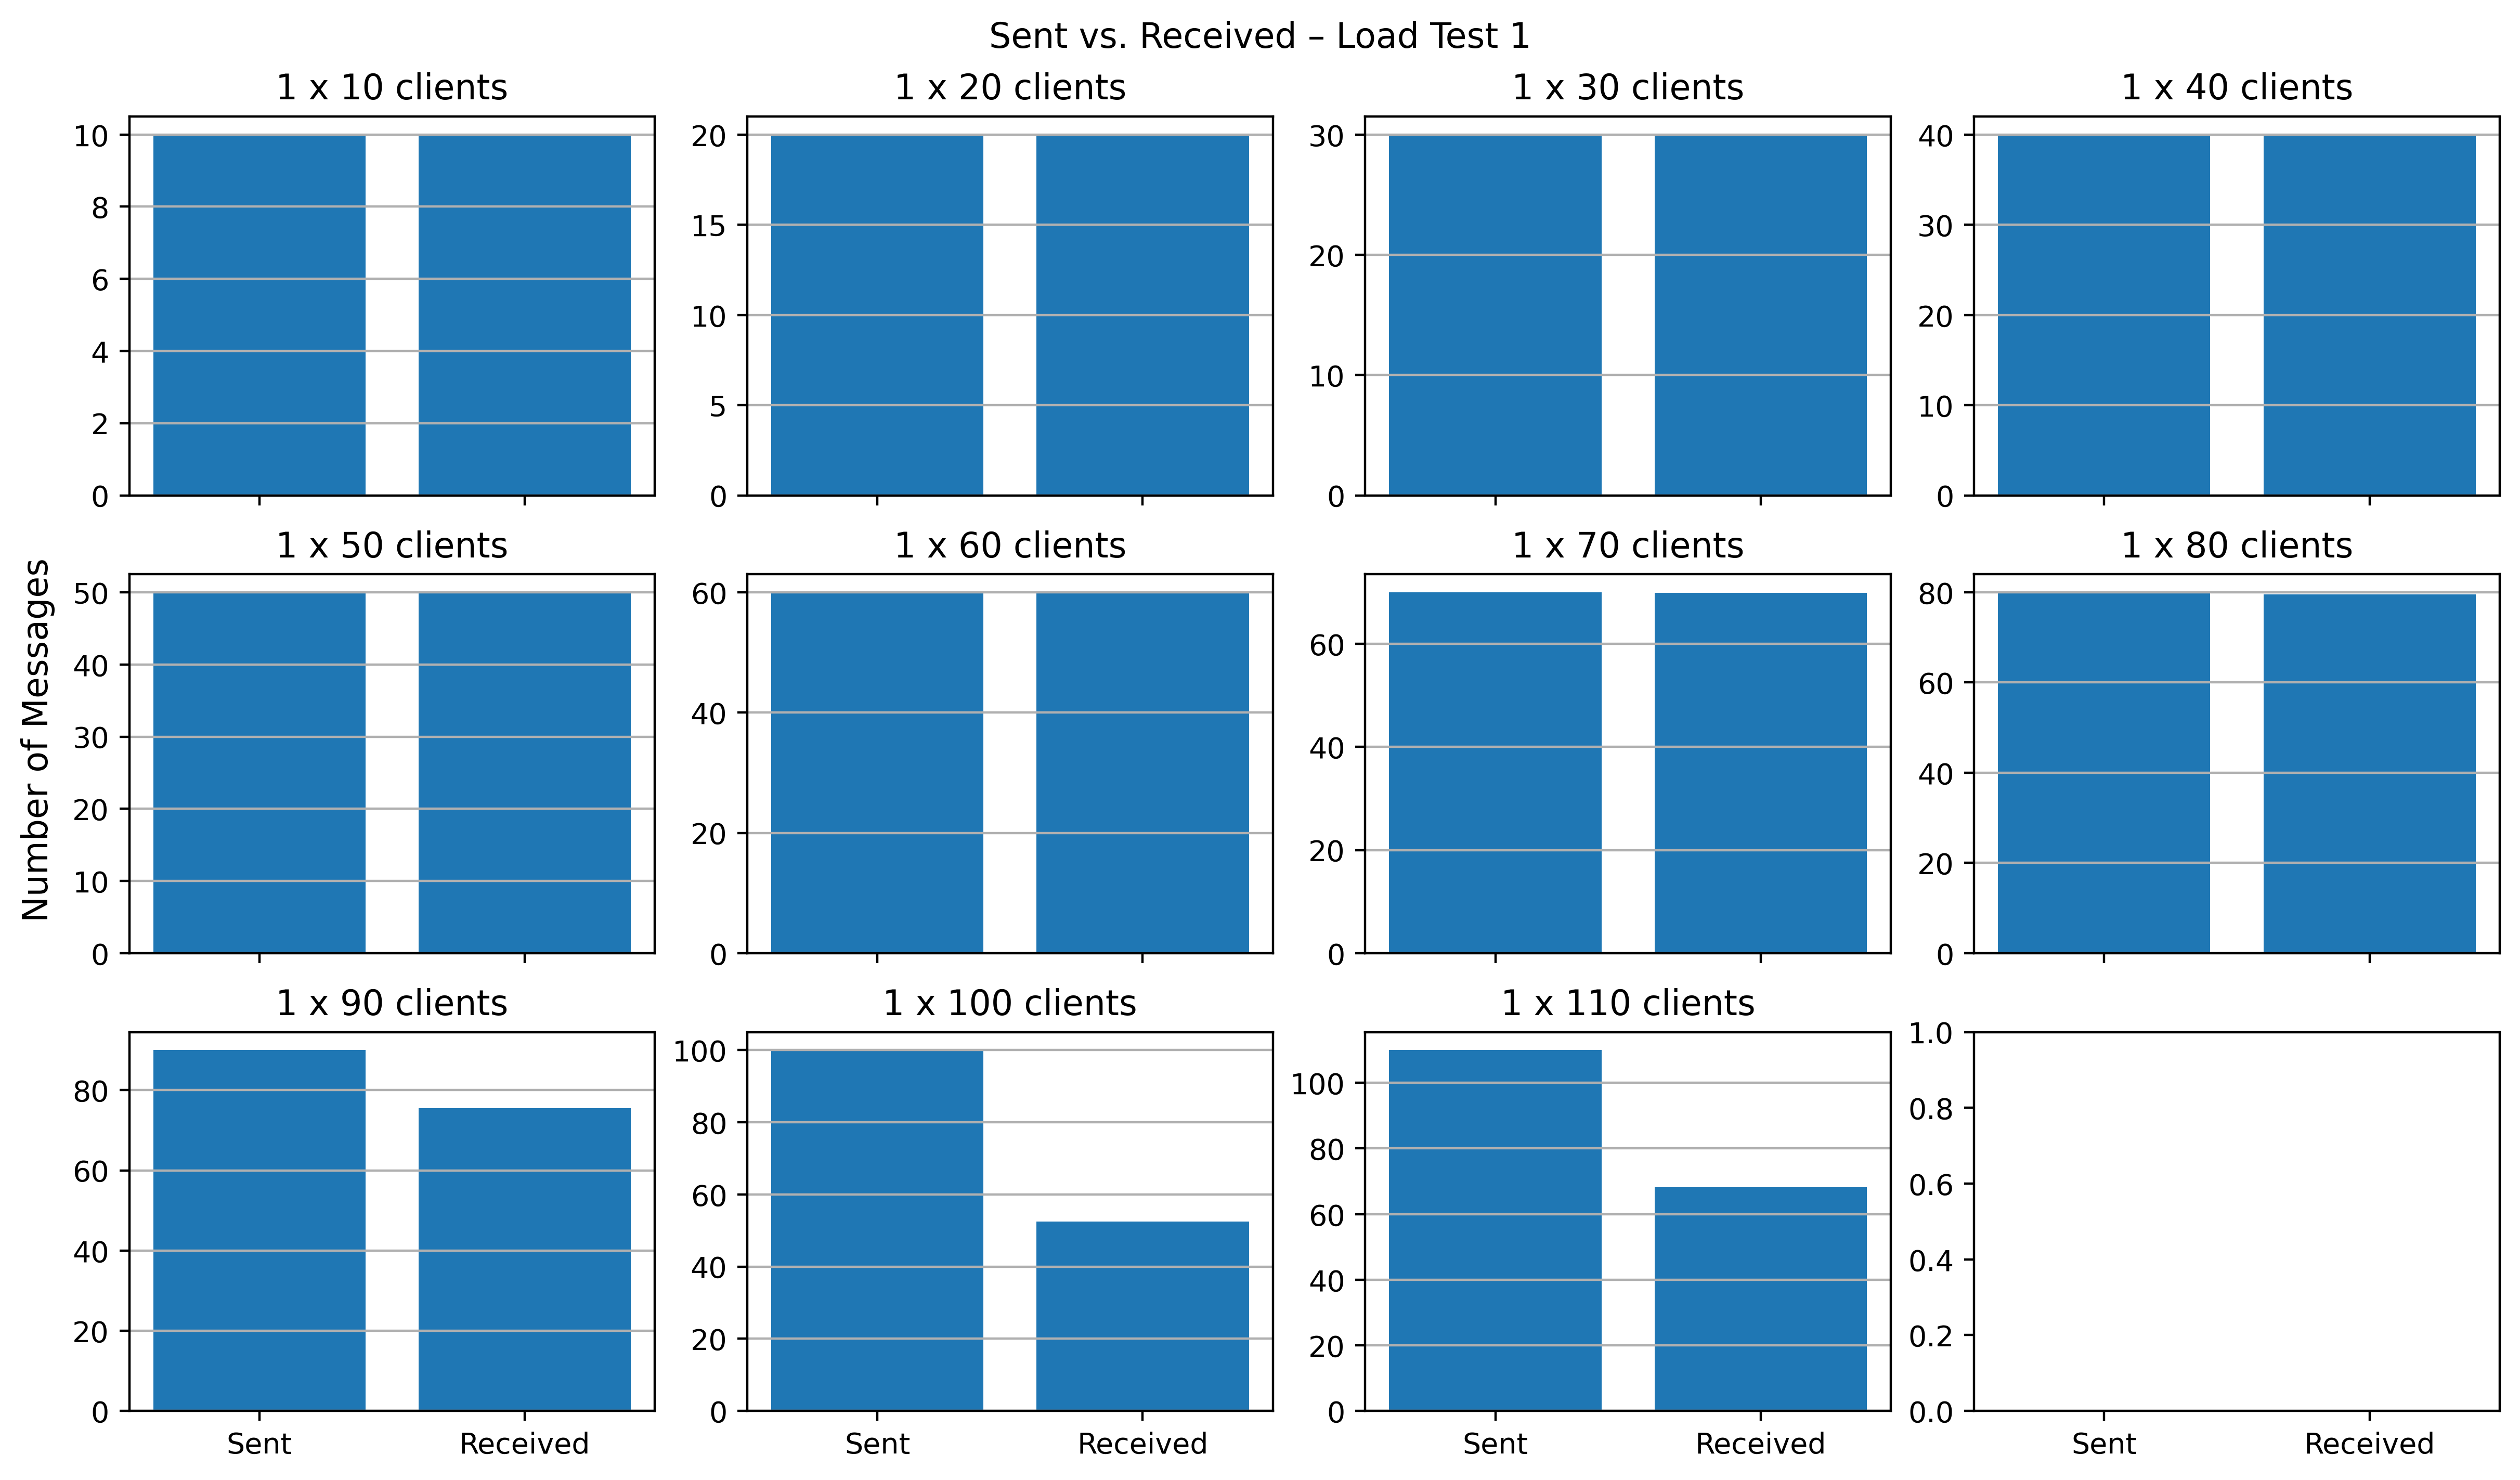

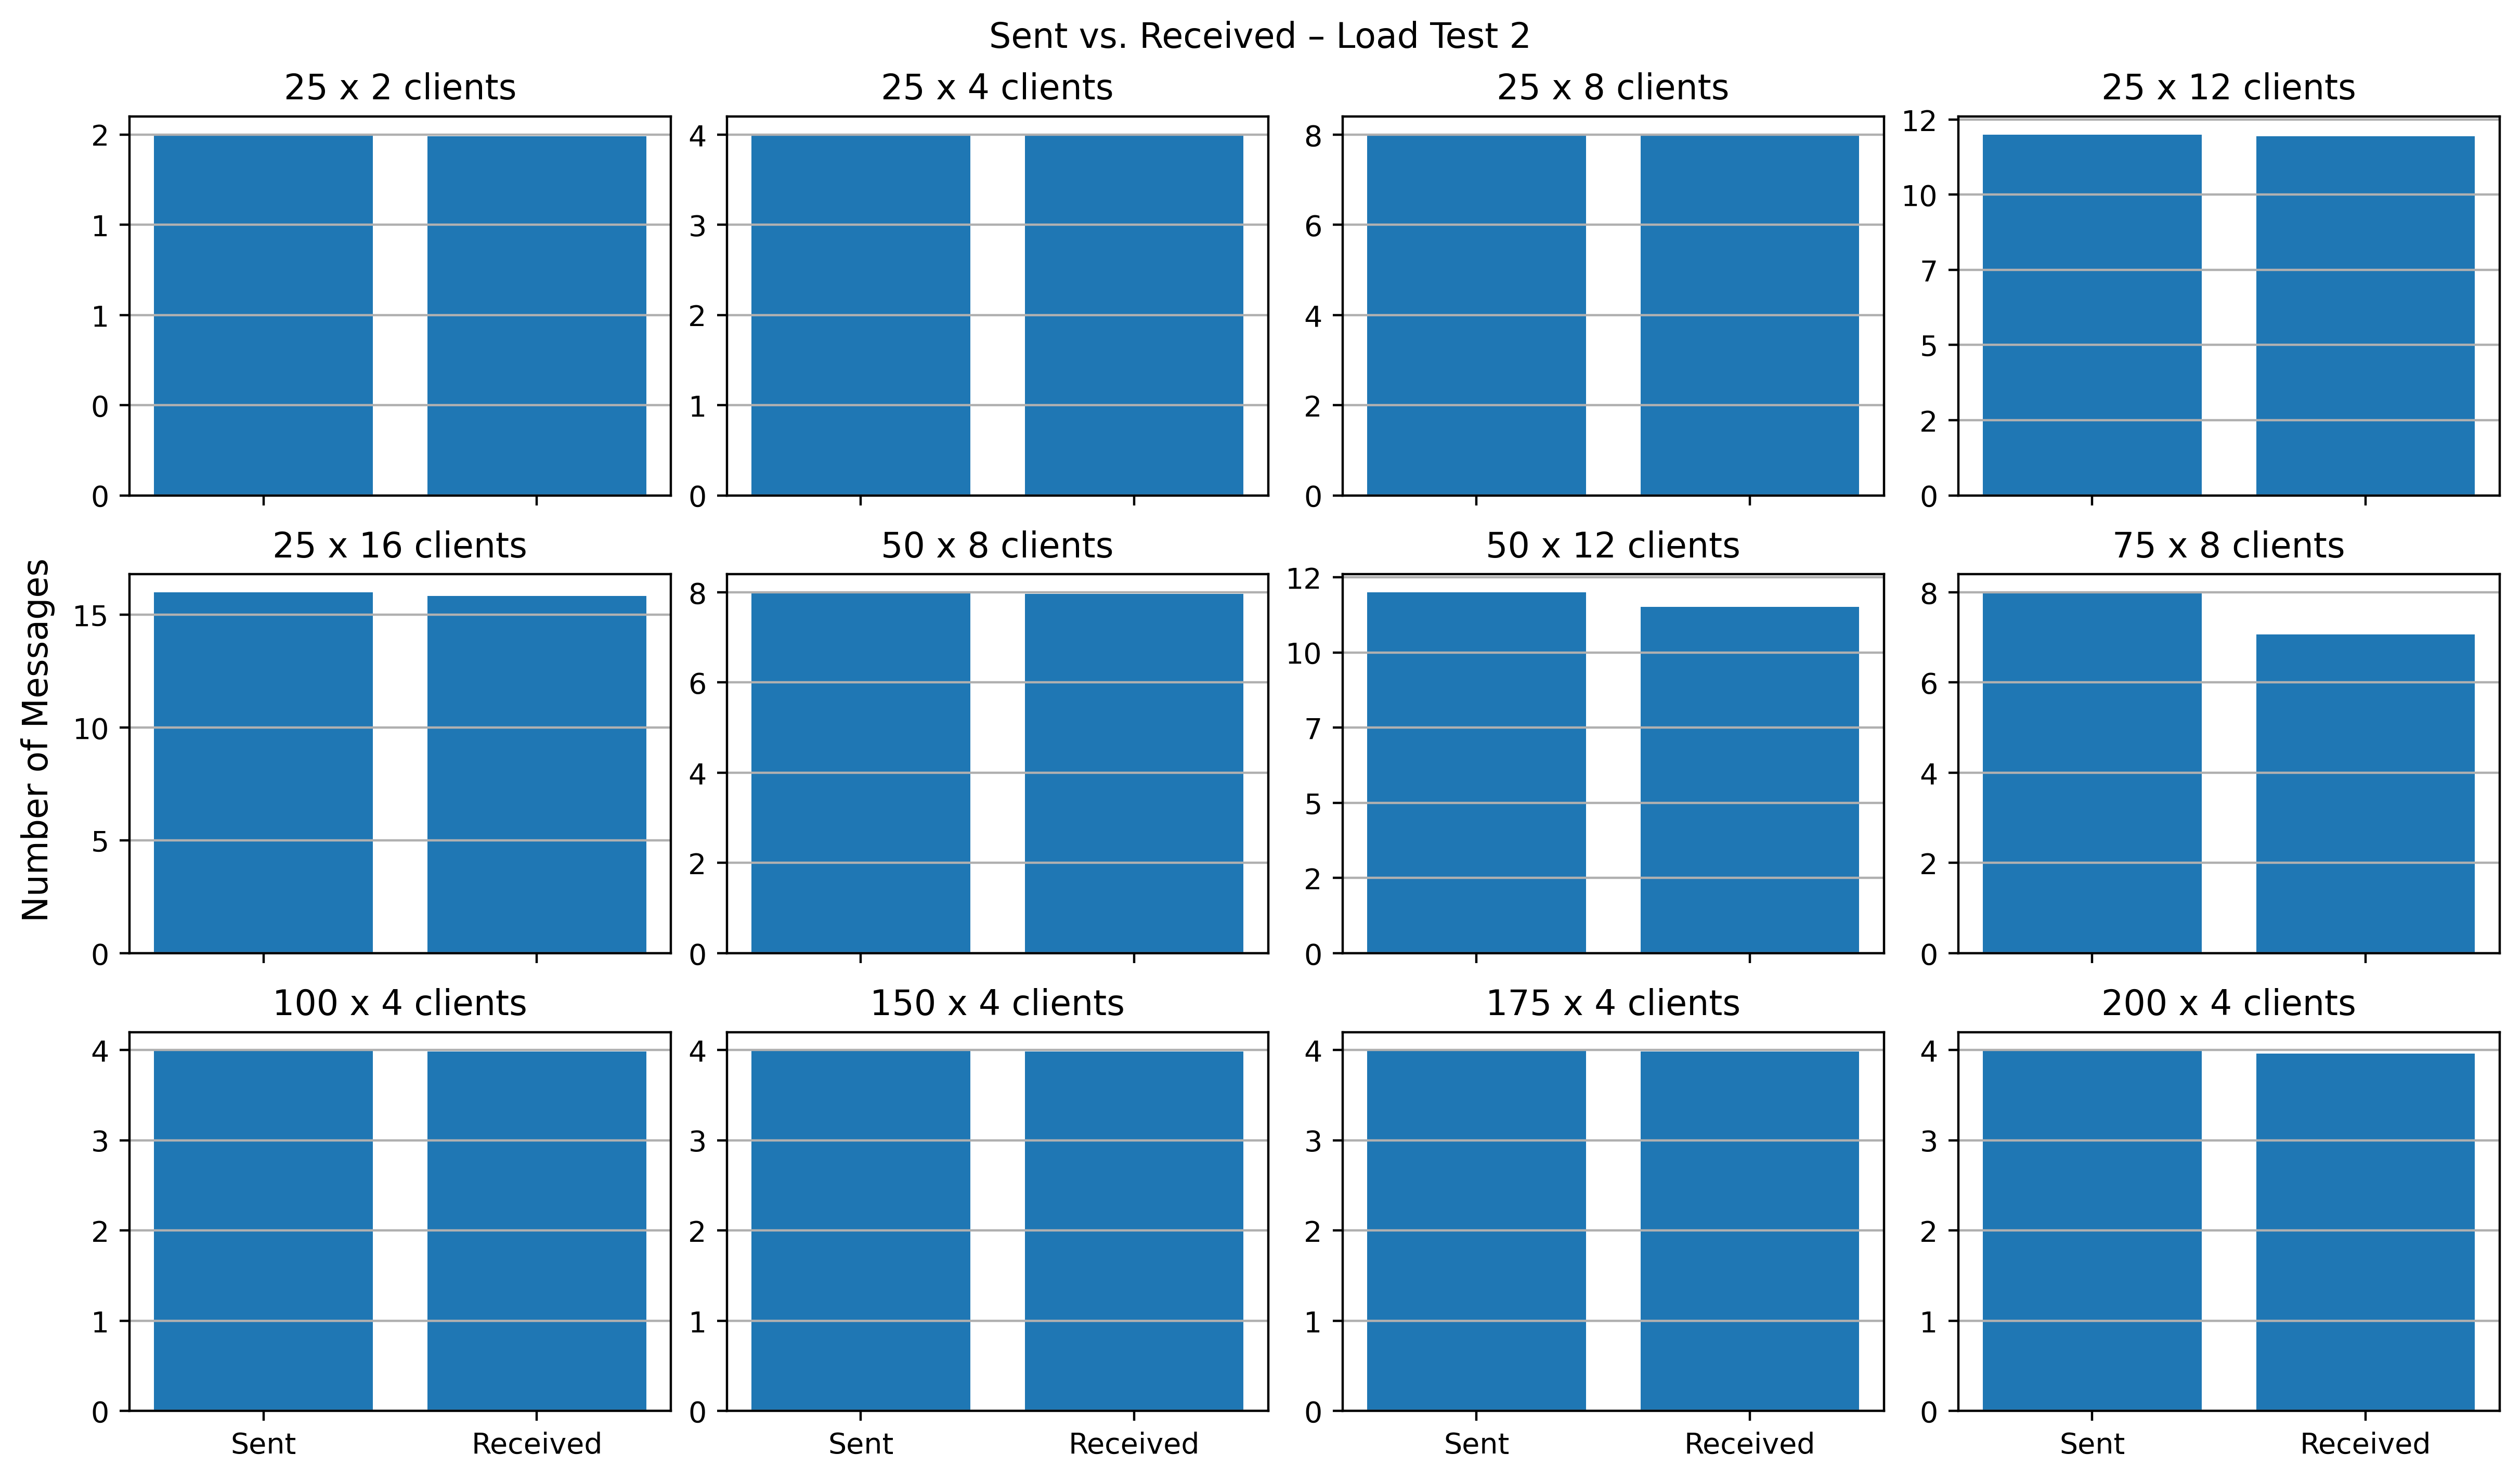

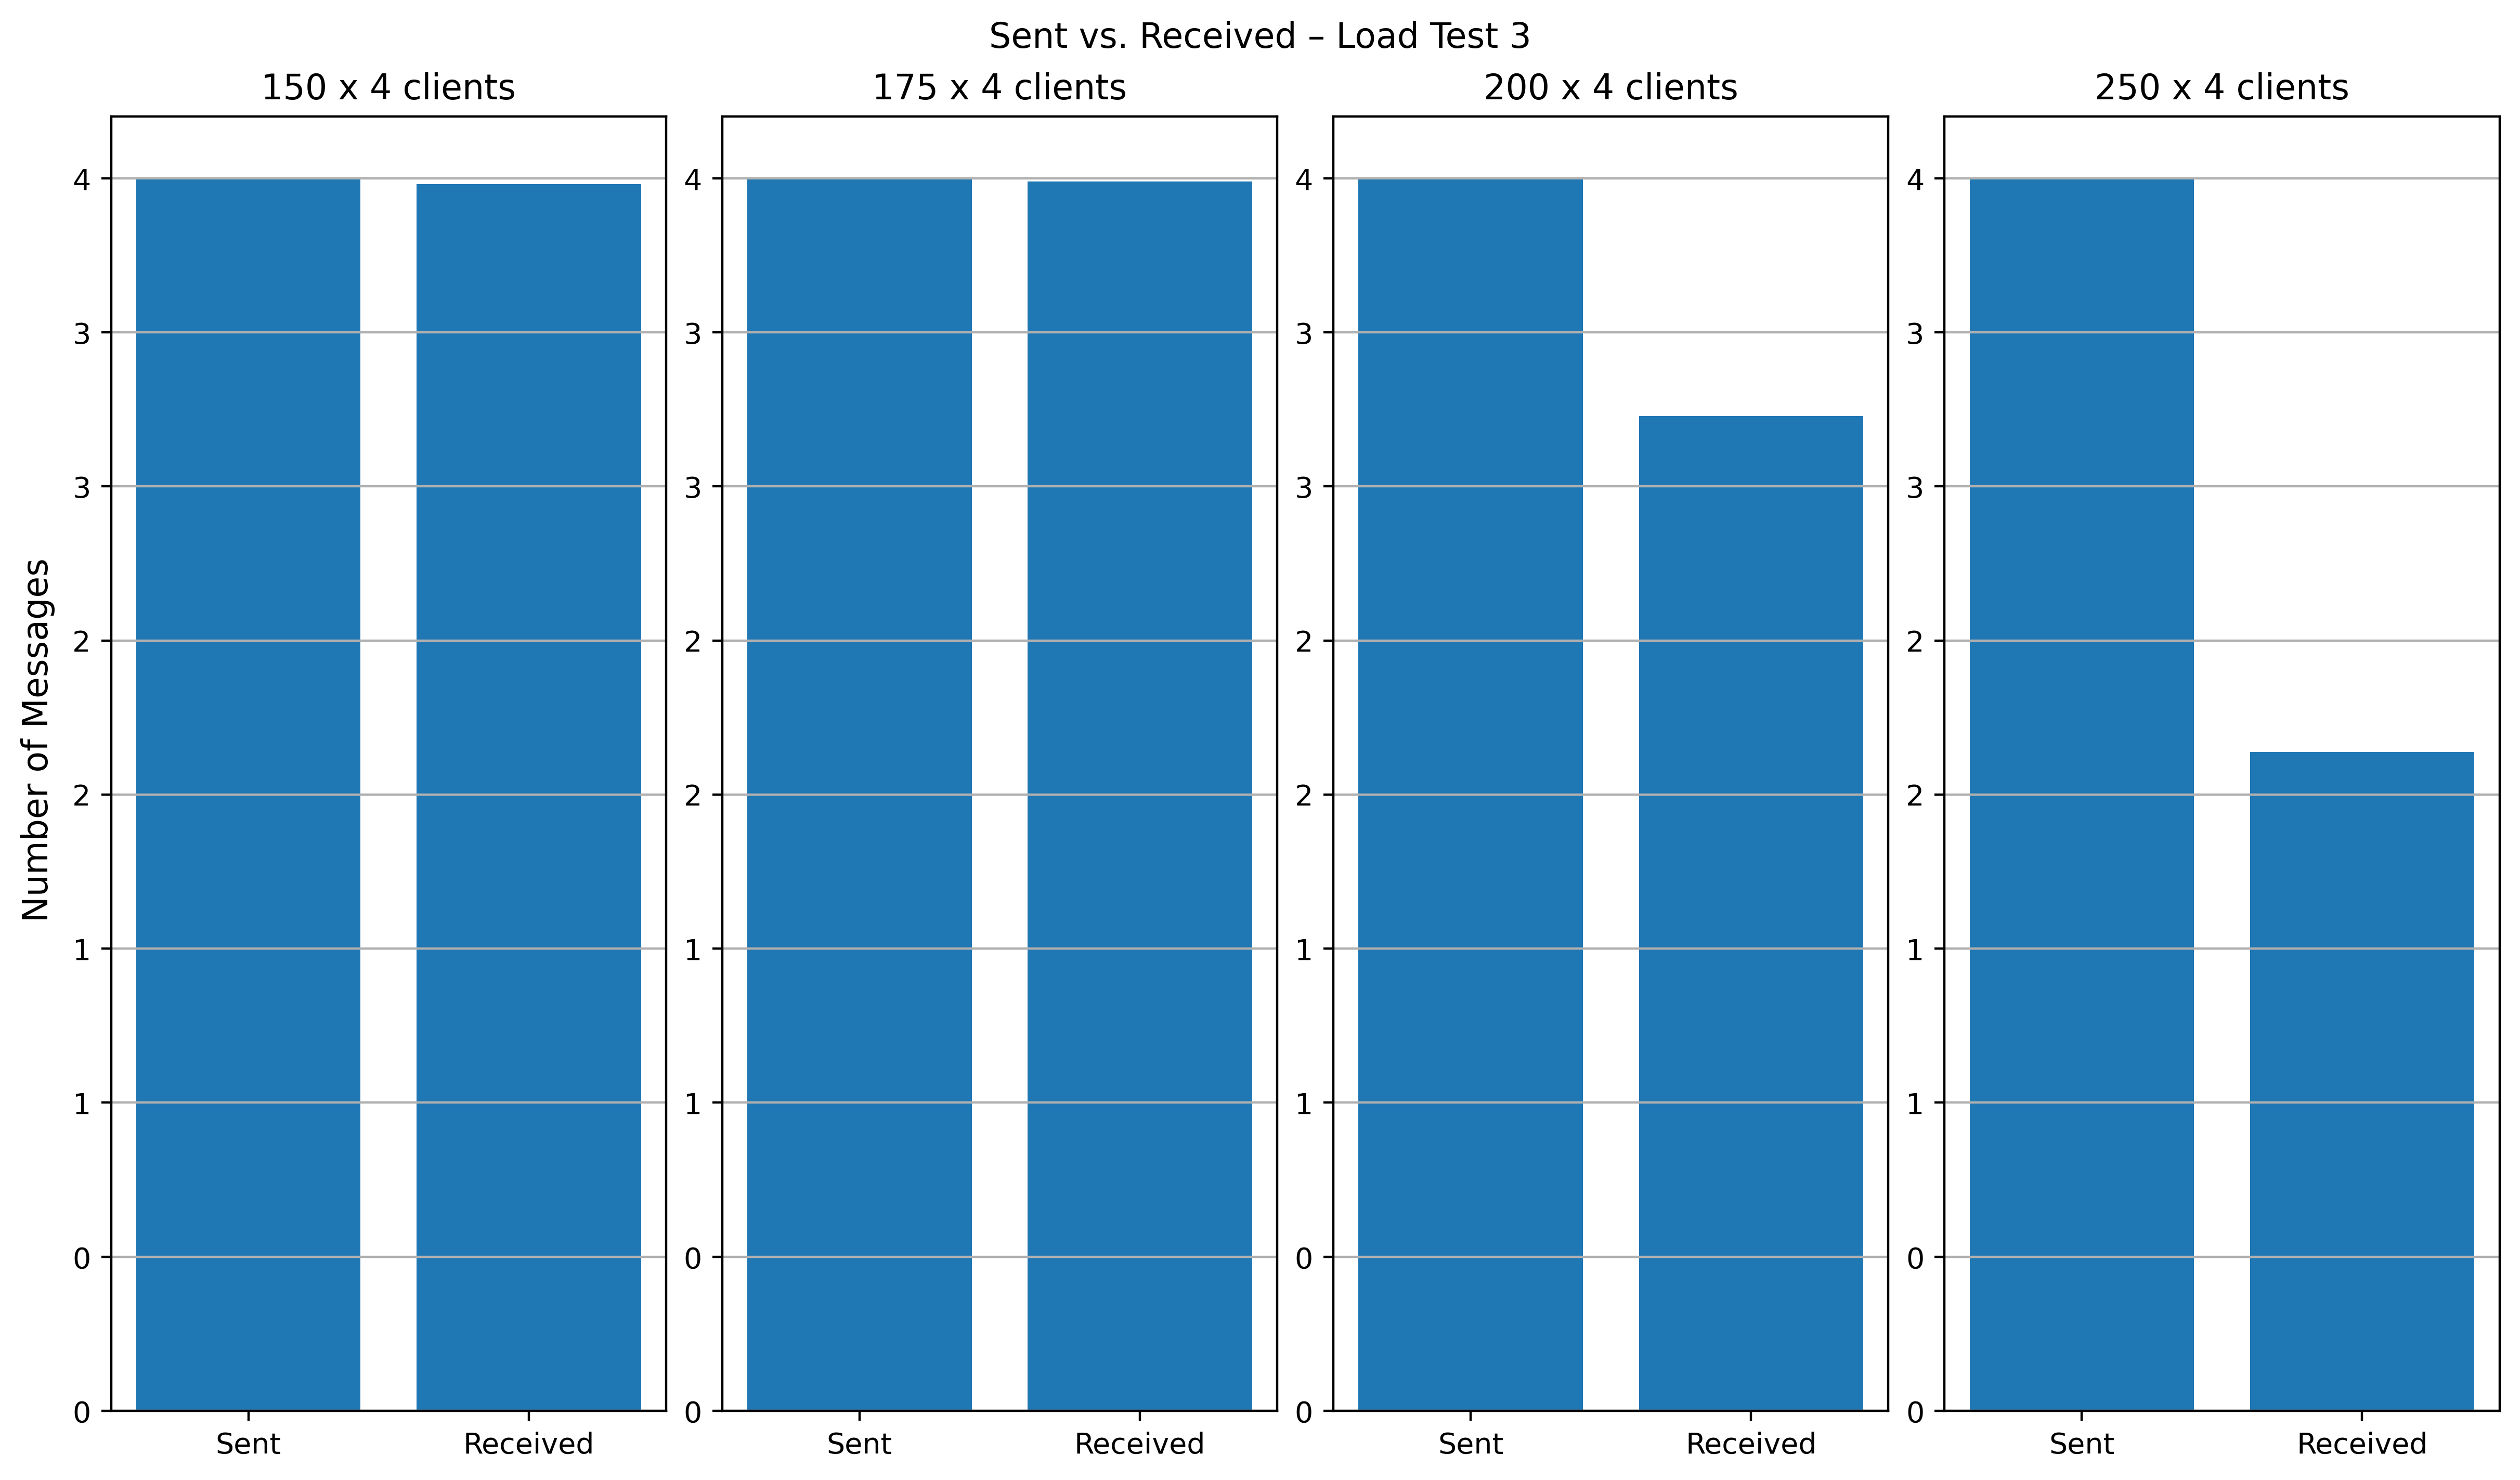

In [88]:
def render_received_vs_sent(test, files: list[str], filename: str | None = None):
    categories = ["Sent", "Received"]

    fig, axs = plt.subplots(
        int(np.ceil(len(files) / 4)),
        4,
        figsize=(12, 7),
        constrained_layout=True,
        sharex=True,
    )

    axs = axs.flatten()

    for ax, file in zip(axs, files):
        df = pd.read_csv(file)

        x_pos = np.arange(2)

        ax.bar(x_pos, [df[cat.lower()].mean() for cat in categories], align="center")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(categories)
        room_count, room_size = parse_filename(file)
        ax.set_title(f"{room_count} x {room_size} clients")
        ax.yaxis.grid(True)

        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ","))
        )

    fig.suptitle(f"Sent vs. Received – Load Test {test}")
    fig.supylabel("Number of Messages")
    fig.set_dpi(400)

    if filename:
        plt.savefig(filename)
    plt.show()


for test in tests:
    latency_files, svr_files = get_files(test)
    render_received_vs_sent(test, svr_files, f"out/sent-vs-received_test-{test}.png")
